# Modelos de Recomendação Baseados em Similaridade de Conteúdo

In [1]:
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.spatial.distance import cdist
from IPython.display import display
from sklearn.metrics import davies_bouldin_score, silhouette_score
import sys
sys.path.append('../auxiliarScripts')
from dataset_reader import SpotifyPlaylistDataset
from yellowbrick.cluster import KElbowVisualizer

### Carrega e Normaliza os Dados

In [45]:
dataset = SpotifyPlaylistDataset(verbose=False)

In [3]:
tracks = pd.read_csv('../tracks/tracks.csv', index_col='id')
tracks

,name,duration_ms,artists,explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature
id,,,,,,,,,,,,,,,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,Yesterday's Trash,52213,"{""(24OGO7fr96L0azkG3pZZa2,\""Modern Life Is War...",t,0,0.004530,0.324,0.971,0.012800,0,0.3340,-3.168,1,0.0548,95.721,4
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,promise [interlude],88888,"{""(5b0XQwyoJBFd3MwL2YxEPO,Nohidea)""}",f,0,0.833000,0.545,0.495,0.629000,11,0.3860,-13.538,1,0.1020,62.631,4
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,Requiem - Alex Vidal Remix,564720,"{""(6WrPC9g41hy7LUnpxdy6u7,\""Alex Vidal\"")"",""(2...",f,0,0.033200,0.695,0.592,0.892000,0,0.5790,-9.588,1,0.0345,125.008,4
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,Kaké,245356,"{""(44DhAhLWsSFvSqVXDUruVE,\""Young Paris\"")""}",t,0,0.000440,0.450,0.629,0.895000,7,0.1080,-7.059,1,0.1460,193.228,3
spotify:track:16axQgz02GFMiU2xKMT4qJ,F the Bull$h1t - Original Mix,315773,"{""(2ohlvFf9PBsDELdRstPtlP,\""Ferry Corsten\"")""}",f,0,0.000927,0.846,0.707,0.903000,6,0.0666,-5.949,0,0.1270,127.970,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,Waking Up The Dawn,294333,"{""(7beSXA7nBwZ5xJ8jUa77ZL,\""Michael English\"")""}",f,2,0.109000,0.538,0.609,0.000006,5,0.0948,-7.392,1,0.0275,87.960,4
spotify:track:1nvTse7nkCr8tO8LOAell4,Here Comes the Star,202733,"{""(48YxSlb23RAaCd4RyHcV9V,\""Herman's Hermits\"")""}",f,0,0.698000,0.339,0.325,0.000005,2,0.5550,-11.445,1,0.0252,91.286,4
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,You're With Me,293546,"{""(0WTXG5dSB0wpykAqPpEmFl,UnchainD)""}",f,0,0.018600,0.482,0.443,0.000345,4,0.1100,-8.622,1,0.0276,144.962,4


#### Para pegar uma música: tracks.loc[id]
#### Para pesquisar o nome de uma música e pegar seu id: tracks.index[tracks['name'] == "nome música"]

#### Deixa apenas as features que serão utilizadas e separa um dataframe com nome e artistas para poderem ser retornados no final

In [4]:
tracks[tracks['name'] == 'Fantasia in D Minor, K.397']

,name,duration_ms,artists,explicit,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature
id,,,,,,,,,,,,,,,,
spotify:track:3ekVOvu8iE33gEGLDq9lxJ,"Fantasia in D Minor, K.397",436560,"{""(4NJhFmfw43RLBLjQvxDuRS,\""Wolfgang Amadeus M...",f,15,0.993,0.392,0.0249,0.946,2,0.114,-28.685,1,0.0632,134.872,4
spotify:track:2H80pfVM3uQQCdb86hmhxf,"Fantasia in D Minor, K.397",324186,"{""(4NJhFmfw43RLBLjQvxDuRS,\""Wolfgang Amadeus M...",f,31,0.973,0.393,0.1460,0.786,7,0.114,-25.025,1,0.0438,128.803,4
spotify:track:5NEQySJDwnf3O7bISjnQ6q,"Fantasia in D Minor, K.397",316653,"{""(4NJhFmfw43RLBLjQvxDuRS,\""Wolfgang Amadeus M...",f,0,0.994,0.385,0.0499,0.906,2,0.107,-25.262,1,0.0543,125.897,4


In [5]:
# Set de músicas de teste
classical_music = 'spotify:track:4Znak3UnsXjRYQDSK0oP6V' # (clássica) Symphony No.5 in C minor, Op.67 | Beethoven

rap_music = 'spotify:track:5Tou8lYopj9qCIFBFBomZ5' # (rap) Yoshi City | Yung Lean

rap_music2 = 'spotify:track:15TJBhID2NsMMp2etO0B03' # (rap) Wrist Cry | Bladee

anime_music = 'spotify:track:0zFRHGYU1zP6q45qbils3z' # (anime) Go!!! | Flow

rock_music = 'spotify:track:2hmibAtdObO8F4tnhLENuQ' # (rock) Reptilia | The Strokes

eletronic_music = 'spotify:track:47qYqGPgMTh3l1PRKBHEfI' # (eletronic) Unity | FatRat

piano_music = 'spotify:track:3ekVOvu8iE33gEGLDq9lxJ' # (piano) Fantasia in D Minor | K.397




In [6]:
# guarda o id e nome
music_ids = tracks[['name', 'artists']]

# remove colunas que não serão utilizadas
tracks.drop(['name', 'artists', 'explicit', 'time_signature', 'mode', 'key', 'duration_ms', 'popularity'], axis=1, inplace=True)
music_ids

,name,artists
id,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,Yesterday's Trash,"{""(24OGO7fr96L0azkG3pZZa2,\""Modern Life Is War..."
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,promise [interlude],"{""(5b0XQwyoJBFd3MwL2YxEPO,Nohidea)""}"
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,Requiem - Alex Vidal Remix,"{""(6WrPC9g41hy7LUnpxdy6u7,\""Alex Vidal\"")"",""(2..."
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,Kaké,"{""(44DhAhLWsSFvSqVXDUruVE,\""Young Paris\"")""}"
spotify:track:16axQgz02GFMiU2xKMT4qJ,F the Bull$h1t - Original Mix,"{""(2ohlvFf9PBsDELdRstPtlP,\""Ferry Corsten\"")""}"
...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,Waking Up The Dawn,"{""(7beSXA7nBwZ5xJ8jUa77ZL,\""Michael English\"")""}"
spotify:track:1nvTse7nkCr8tO8LOAell4,Here Comes the Star,"{""(48YxSlb23RAaCd4RyHcV9V,\""Herman's Hermits\"")""}"
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,You're With Me,"{""(0WTXG5dSB0wpykAqPpEmFl,UnchainD)""}"


In [7]:
tracks

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,0.004530,0.324,0.971,0.012800,0.3340,-3.168,0.0548,95.721
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,0.833000,0.545,0.495,0.629000,0.3860,-13.538,0.1020,62.631
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,0.033200,0.695,0.592,0.892000,0.5790,-9.588,0.0345,125.008
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,0.000440,0.450,0.629,0.895000,0.1080,-7.059,0.1460,193.228
spotify:track:16axQgz02GFMiU2xKMT4qJ,0.000927,0.846,0.707,0.903000,0.0666,-5.949,0.1270,127.970
...,...,...,...,...,...,...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,0.109000,0.538,0.609,0.000006,0.0948,-7.392,0.0275,87.960
spotify:track:1nvTse7nkCr8tO8LOAell4,0.698000,0.339,0.325,0.000005,0.5550,-11.445,0.0252,91.286
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,0.018600,0.482,0.443,0.000345,0.1100,-8.622,0.0276,144.962


### Função de normalização usando fórmula do MinMaxScaler do SKLearn 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [8]:
def scaler(X, min_=None, max_=None):
    if not min_:
        min_ = X.min()
    if not max_:
        max_ = X.max()
    return X.map(lambda x: (x - min_) / (max_ - min_))

### Normalização dos dados que não estão normalizados

In [9]:
#tracks['duration_ms'] = scaler(tracks['duration_ms'])
#tracks['popularity'] = scaler(tracks['popularity'], min_=0, max_=100)
#tracks['key'] = scaler(tracks['key'])
tracks['loudness'] = scaler(tracks['loudness'], min_=-60, max_=0)
tracks['tempo'] = scaler(tracks['tempo'])

In [10]:
tracks

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,
spotify:track:0hJkacKTAr8GZeKwcPuUk2,0.004530,0.324,0.971,0.012800,0.3340,0.875375,0.0548,0.382904
spotify:track:1xjFMVi8pn5VIWiqrdxAMc,0.833000,0.545,0.495,0.629000,0.3860,0.715648,0.1020,0.250537
spotify:track:2ahiPTFTfIPs7UKqjKhJkc,0.033200,0.695,0.592,0.892000,0.5790,0.776489,0.0345,0.500058
spotify:track:2z5xCMFxAo7dn6zsu6UwL9,0.000440,0.450,0.629,0.895000,0.1080,0.815443,0.1460,0.772952
spotify:track:16axQgz02GFMiU2xKMT4qJ,0.000927,0.846,0.707,0.903000,0.0666,0.832540,0.1270,0.511907
...,...,...,...,...,...,...,...,...
spotify:track:6OjPR4Y7VGDBaJMSD3QA0t,0.109000,0.538,0.609,0.000006,0.0948,0.810314,0.0275,0.351858
spotify:track:1nvTse7nkCr8tO8LOAell4,0.698000,0.339,0.325,0.000005,0.5550,0.747886,0.0252,0.365163
spotify:track:5vKVjyFJNtfdHXzzLaWbpz,0.018600,0.482,0.443,0.000345,0.1100,0.791368,0.0276,0.579878


## Criando Modelo de Similaridade

In [11]:
class Similarity:
    def __init__(self, distance='euclidean'):
        self.distance = distance
        self.tracks = None
        
    def fit(self, tracks, id_tracks):
        self.tracks = tracks
        self.id_tracks = id_tracks
    
    def recommend(self, user_tracks, n_tracks=5):
        # cria a música média
        mean_track = np.mean(user_tracks, axis=0)
        
        # calcula distancias e pega os indices das k músicas com menores distâncias
        dists = cdist([mean_track], self.tracks, self.distance)[0]
        k_arg_dists = np.argpartition(dists, n_tracks+1)[:n_tracks+1]
        
        k_ids = self.id_tracks.iloc[k_arg_dists]
        k_info = self.tracks.iloc[k_arg_dists]
        k_dists = pd.DataFrame(dists[k_arg_dists], columns=['Distâncias'], index=self.tracks.index[k_arg_dists])
        
        # retorna um dataframe com informação do nome, artistas, distância e features ordenadas pela distância
        return pd.concat([k_dists, k_ids, k_info], axis=1).sort_values(by=['Distâncias'])
        

### Teste de Recomendador para Música Única

Tabela de Acerto

MB - Muito Bom

B - Bom

OK - Ok 

R - Ruim

MR - Muito Ruim

/  -  Sem informação

In [18]:
sim = Similarity(distance='euclidean')
sim.fit(tracks, music_ids)
sim.recommend([tracks.loc[classical_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4Znak3UnsXjRYQDSK0oP6V,0.000000,"Symphony No.5 in C minor, Op.67: 1. Allegro co...","{""(2wOqMjp9TyABvtHdOSOTUS,\""Ludwig van Beethov...",0.900,0.309,0.307,0.745,0.0929,0.764198,0.0443,0.402445
spotify:track:061pN2sHhLNI3vAPIHVn2R,0.053293,Stranger On The Shore,"{""(5bdgb81IJMXag724quaNSA,\""Acker Bilk\"")"",""(4...",0.940,0.319,0.322,0.742,0.1040,0.740200,0.0359,0.390764
spotify:track:1pKwem2d9YXLd4LUParsid,0.055306,THEME FROM LOVE STORY,"{""(1sLpCr5xThZkGHLw4H0mNE,\""101 Strings Orches...",0.900,0.289,0.315,0.716,0.1050,0.728632,0.0288,0.412557
spotify:track:1mBIJRcbAec5EkveeYrPCa,0.065940,I Got Lost,"{""(267VY6GX5LyU5c9M85ECZQ,\""Dinosaur Jr.\"")""}",0.875,0.354,0.330,0.748,0.0942,0.738983,0.0264,0.388224
spotify:track:5GA90eh24Ro95k9tywfuHo,0.069033,Unless a Grain of Wheat,"{""(3PF6OyABdvKssByiQ8Imn9,\""Forbes Ministry of...",0.886,0.359,0.292,0.738,0.1310,0.756327,0.0276,0.404209
spotify:track:42B96jvtflrB3Xo7rcJnl2,0.069542,American Civil War Fantasy,"{""(6lxjjQH0jBo0mEHO5WxFnS,\""United States Coas...",0.910,0.319,0.303,0.773,0.0794,0.741124,0.0388,0.458044


OK, MB, R, R, B 

In [19]:
sim.recommend([tracks.loc[rap_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:5Tou8lYopj9qCIFBFBomZ5,0.000000,Yoshi City,"{""(67lytN32YpUxiSeWlKfHJ3,\""Yung Lean\"")""}",0.476,0.546,0.530,0.000000,0.0955,0.784637,0.211,0.512863
spotify:track:0kDEzhgtVZfYMVm7VR7f03,0.060607,Hero,"{""(0fLP4yWtS7wE0S0QbI4IYG,\""Chan Dizzy\"")""}",0.436,0.563,0.539,0.000000,0.1220,0.796189,0.232,0.492210
spotify:track:2CIzsTwVjIWMh64Nw6S3Lp,0.061630,Heartbroken Forever,"{""(5WF5qT6fSfyd3RC2p8qpEX,\""Tender Forever\"")""}",0.518,0.534,0.509,0.000000,0.1130,0.786131,0.217,0.479625
spotify:track:4vh8S4hTWAz3DHjysBo0ai,0.061667,Cocaine,"{""(4YUcg2ee9TxMNdjhAxzZBF,Ashh)"",""(44JOYPmzHzT...",0.498,0.584,0.506,0.000028,0.1110,0.772084,0.181,0.511899
spotify:track:4va49u7BqBLAmpu7WnyuQ1,0.064300,Heartbreaker,"{""(4mwXUEKaW4ftbncf9Hi58l,Tank)""}",0.496,0.510,0.500,0.000000,0.0637,0.805677,0.217,0.519827
spotify:track:00VWUa96Clte4uNEv963vn,0.070310,Évite la,"{""(1cA379ILgR07m7XQVXyP6Q,Sneazzy)"",""(5olcgTze...",0.442,0.603,0.538,0.000049,0.1010,0.786347,0.232,0.513463


B, B, MB, R, B

In [20]:
sim.recommend([tracks.loc[rap_music2]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:15TJBhID2NsMMp2etO0B03,0.000000,Wrist Cry,"{""(2xvtxDNInKDV4AvGmjw6d1,Bladee)""}",0.366,0.634,0.428,0.003270,0.280,0.738906,0.0284,0.439895
spotify:track:5X7yF7u1fVGS4EyekX6ewM,0.025748,"Miami, My Amy","{""(0bc7dhY6YXL35m1G0jVwuW,\""Keith Whitley\"")""}",0.354,0.646,0.441,0.000002,0.290,0.746592,0.0272,0.433999
spotify:track:1OJpQrusmejmwnvsFQqF8c,0.035643,Annie,"{""(05Pp7SeRkvE236OxUF2qmo,Yarn)""}",0.341,0.645,0.443,0.000027,0.290,0.752599,0.0276,0.440767
spotify:track:3zyUs7o9iKVhb1xuSSi0t8,0.038462,Compañero de Mi Alma,"{""(3NUe53SAgcR19GtgfSKTpW,\""Óscar Medina\"")""}",0.374,0.646,0.413,0.000000,0.265,0.711628,0.0302,0.431942
spotify:track:0Avs2CCYWfhanvCMc5qtnK,0.040308,Friends - Acoustic,"{""(6jO0ArPsbU6gg4GehuCjoF,\""Eliza and the Bear...",0.331,0.633,0.429,0.000006,0.299,0.743912,0.0293,0.440395
spotify:track:0DT4o6GdCw5Uxqb5EDIqSf,0.043744,Don't Try To Explain,"{""(6iDaoPZVgxrTkndDCisX8F,\""Keb' Mo'\"")""}",0.386,0.649,0.452,0.000469,0.278,0.762904,0.0393,0.442339


MR, MR, MR, /, MR

In [21]:
sim.recommend([tracks.loc[anime_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0zFRHGYU1zP6q45qbils3z,0.000000,GO!!!,"{""(3w2HqkKa6upwuXEULtGvnY,FLOW)""}",0.0508,0.604,0.978,0.000000,0.228,0.891595,0.0573,0.536584
spotify:track:5X31etfs08Q3H7WenRHWoc,0.038166,UNBALANCE,"{""(7Jo4alROJu9Smj8IZahiP1,Dios/signalP)""}",0.0471,0.590,0.956,0.004540,0.242,0.881752,0.0395,0.548101
spotify:track:5XuGyBKKFrCoz4iwvm7k7s,0.042463,I Hope,"{""(6KhH771vq2X2Aom91nNzpZ,FTISLAND)""}",0.0580,0.590,0.976,0.000000,0.197,0.892426,0.0641,0.559893
spotify:track:5z8ynRCdK17BWNLxL8rrfZ,0.043371,Take It Like a Man,"{""(72OaDtakiy6yFqkt4TsiFt,Cher)""}",0.0678,0.613,0.950,0.000000,0.243,0.889977,0.0723,0.520019
spotify:track:62pM9hM5FdqPuUKkZTmENp,0.043751,fanfare,"{""(0udR1QMfgT37SQnL1QClTU,\""Bullet Train\"")""}",0.0426,0.613,0.943,0.000000,0.208,0.883323,0.0651,0.540000
spotify:track:4618Zrqjfr2nqeXibDUIFJ,0.044536,Make me fly - The Out In Space Story Continues,"{""(40edmg1pVhEKklKU7BCo1n,\""Timur Rodriguez\"")""}",0.0263,0.620,0.967,0.000008,0.250,0.889069,0.0475,0.516095


MB, MB, R, MB, R

In [22]:
sim.recommend([tracks.loc[rock_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2hmibAtdObO8F4tnhLENuQ,0.000000,Reptilia,"{""(0epOFNiUfyON9EYx7Tpr6V,\""The Strokes\"")""}",0.000597,0.488,0.650,0.714,0.1010,0.845463,0.0336,0.632077
spotify:track:79NvOn5z1gmBhZMvAdaZzv,0.039079,L'innocent,"{""(0iF2gedsSjoVHRUh5vXSdu,\""Cirque du Soleil\"")""}",0.013300,0.496,0.638,0.687,0.0973,0.827134,0.0296,0.640021
spotify:track:1Dc4H1XvXdsRqrD6WZxYKZ,0.056278,Lower Down,"{""(4zxyqU3xB0RrPX9rL9RNln,\""Lo Tom\"")""}",0.000043,0.483,0.699,0.714,0.1210,0.853781,0.0292,0.616192
spotify:track:6LVbyUVhbhhNN7uc2bqEqg,0.060271,Strip The Soul,"{""(5NXHXK6hOCotCF8lvGM1I0,\""Porcupine Tree\"")""}",0.001920,0.537,0.670,0.716,0.1150,0.830538,0.0470,0.616992
spotify:track:3JxGBrNcvunLiznL1JJzZN,0.066181,Is This Real?,"{""(0sTTw3dw3EA0c7NaZnrJd2,Wipers)""}",0.003300,0.456,0.695,0.714,0.1310,0.839302,0.0324,0.651678
spotify:track:1QlweZy3kMgha3UlkQbjMS,0.066457,Take This Lying Down,"{""(2VS0tRcCbiMkelzGoZo9XP,\""The Lucksmiths\"")""}",0.002320,0.479,0.631,0.711,0.0732,0.797268,0.0264,0.603527


OK, B, B, B, R

In [23]:
sim.recommend([tracks.loc[eletronic_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:47qYqGPgMTh3l1PRKBHEfI,0.000000,Unity,"{""(3OKg7YbOIatODzkRIbLJR4,TheFatRat)""}",0.004240,0.707,0.880,0.03790,0.0534,0.874713,0.0317,0.420034
spotify:track:6Gd317x1MJZ378T6xbCpGI,0.041626,Jacuzzi Jam - Original Mix,"{""(3uMZB1LatgHJCRe7DBtgiK,Syndaesia)""}",0.000565,0.728,0.873,0.03190,0.0659,0.872125,0.0569,0.439915
spotify:track:5HRnngZD7Xgko5swVsuYIk,0.043683,How I Feel,"{""(1fwbNA9Ymk7hPxcxx67paW,\""Brown and Gammon\"")""}",0.002050,0.698,0.889,0.03740,0.0418,0.856692,0.0541,0.447963
spotify:track:3MYStY0UdBrk01XUDfYON1,0.046224,Phoenix - DJ Laszlo Remix,"{""(188VINPQh5dyNfLUkevKqf,\""Olivia Holt\"")"",""(...",0.029200,0.697,0.899,0.01050,0.0407,0.881999,0.0365,0.412001
spotify:track:6DlwyiBUy2b0JQWd6CLAQa,0.046876,Love To Love You Baby - Giorgio Moroder Feat. ...,"{""(2eogQKWWoohI3BSnoG7E2U,\""Donna Summer\"")"",""...",0.019000,0.710,0.878,0.00499,0.0623,0.853303,0.0458,0.432158
spotify:track:5TYIzi4Oa1fiRpDX0mklLN,0.047079,Hunter - Made in June Remix,"{""(4sTQVOfp9vEMCemLw50sbu,Galantis)"",""(0EJYJn2...",0.005150,0.719,0.865,0.00709,0.0827,0.871987,0.0356,0.424062


MB, MB, B, MB, B

In [24]:
sim.recommend([tracks.loc[piano_music]])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3ekVOvu8iE33gEGLDq9lxJ,0.000000,"Fantasia in D Minor, K.397","{""(4NJhFmfw43RLBLjQvxDuRS,\""Wolfgang Amadeus M...",0.993,0.392,0.02490,0.946,0.1140,0.482341,0.0632,0.539516
spotify:track:2CUFmzZhLz1DjE0jPSqsGt,0.030968,"Livre de guitarre dédié au Roy, Suite No. 3 en...","{""(4br5HVmW3Xed5Zvffl0RSU,\""Robert de Visée\"")...",0.993,0.371,0.03750,0.944,0.1080,0.475610,0.0588,0.555473
spotify:track:2tQsfOpi7hC0mUvHLZ00W6,0.032242,"Sentimental Waltz, Op. 51, No. 6: Sentimental ...","{""(3KA4Qo2Ngnk5knbCkiowDI,\""Daria Telizyn\"")""}",0.995,0.395,0.00402,0.930,0.1220,0.484528,0.0469,0.539808
spotify:track:1X5Qxd5vVlvOoVYVJCfAwL,0.032418,Metamorphosis I (arr. for harp),"{""(1xWAOwW7fYZprzRMvR2v9Z,Anonymous )"",""(69lxx...",0.993,0.401,0.03060,0.939,0.1090,0.492553,0.0881,0.551313
spotify:track:28JqEjN2SNFk8NqHQfnvxB,0.032968,"On an Overgrown Path, Pt. 1: IV. The Madonna o...","{""(46xXzoOdtD7SL2PTRq5irp,\""Leoš Janáček\"")"",""...",0.993,0.390,0.00248,0.949,0.0919,0.481909,0.0563,0.533600
spotify:track:2HkJfFiGyBsIu0xWNDER3H,0.033162,"Mazurka No. 21 in C-Sharp Minor, Op. 30, No. 4","{""(7y97mc3bZRFXzT2szRM4L4,\""Frédéric Chopin\"")...",0.994,0.401,0.00789,0.930,0.0969,0.479845,0.0512,0.534060


B, B, B, MB, MB

In [49]:
pl1 = dataset.read_playlist_formatted(1001)['track_uri']
pl2 = dataset.read_playlist_formatted(20_000)['track_uri']

In [48]:
sim.recommend(tracks.loc[pl1])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3XE7ovL0I3yjfzL4cFHrGk,0.085488,Deformed Weight of Hands (No. 28),"{""(7n3HccImPqLtdqtJu5znPt,\""Mary Halvorson Qui...",0.363,0.493,0.586,0.692,0.221,0.728525,0.0742,0.505118
spotify:track:77MEIzDz4oXpG9aeLsadFw,0.095192,The Reburial of Marcus Garvey,"{""(3Nwt4VWRXzMOvQzZRCh9O5,\""Let's Go Bowling\"")""}",0.447,0.482,0.552,0.653,0.209,0.761302,0.0449,0.536912
spotify:track:7DTKXG0rOV6o52sKtRI2uV,0.104535,After Hours At McGann's,"{""(3vGPbjWONbj9blR6NqBAKv,Scythian)""}",0.423,0.425,0.614,0.746,0.252,0.736457,0.0899,0.539152
spotify:track:6jLnHaIW5hqb2d5PVPCwJ3,0.107411,"Eyes of the World - Live at Boston Garden, Bos...","{""(4TMHGUX5WI7OOm53PqSDAT,\""Grateful Dead\"")""}",0.408,0.513,0.567,0.779,0.242,0.727369,0.0358,0.475889
spotify:track:74t2mZAocSvPYyOWnkOh8I,0.107743,So Beautiful (feat. Steve Oliver & Will Donato),"{""(0P8ZQHngOVrCSRbF7ApLlc,\""Daniel D.\"")""}",0.412,0.454,0.525,0.701,0.142,0.742387,0.0555,0.535844
spotify:track:1c96hi9eXiuhPF9UA9q1Np,0.108977,Satisfaction,"{""(3rxIQc9kWT6Ueg4BhnOwRK,\""Quincy Jones\"")""}",0.453,0.438,0.569,0.704,0.148,0.732221,0.0619,0.556629


In [50]:
sim.recommend(tracks.loc[pl2])

,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4XnP0mGXawzgGlRUm8iQ4J,0.043227,All It Takes,"{""(4ThkLup6LmqCUuHuG434zZ,\""Rick Braun\"")""}",0.767,0.498,0.315,0.1160,0.0940,0.783143,0.0288,0.399869
spotify:track:6ydETtTdrGUHyV7sVv8h8B,0.059002,I'd Let You Win,"{""(1NfaYYv3vGwi1ALG33oiLw,\""Little Bear\"")""}",0.790,0.468,0.323,0.1270,0.0842,0.725198,0.0263,0.423454
spotify:track:00wGof6NXHp45tU3ypObFb,0.059663,Kansas City Kitty,"{""(20wwH3Iz7c1PZrvs68O0Jl,\""Fiddlin' Johnny\"")""}",0.801,0.497,0.315,0.0856,0.1390,0.751044,0.0485,0.395057
spotify:track:3wUDz9vYcXp7keO8xgvg7G,0.060349,Bouquet Of Roses,"{""(5NfaORyb548xmt85LGHYFV,\""Clint Eastwood\"")""}",0.754,0.505,0.294,0.0980,0.1180,0.747039,0.0295,0.436227
spotify:track:06jX0IeV1XnMn8eHMUEiPh,0.063675,Porky,"{""(5v74mT11KGJqadf9sLw4dA,\""Cannonball Adderle...",0.757,0.529,0.330,0.1400,0.1060,0.740462,0.0531,0.388396
spotify:track:6EFeEjh4gs1wwVUi3Agtsh,0.064632,The Wolf Man,"{""(4D3lmUAeXE2SMsOKd2B8XQ,\""Luke Bell\"")""}",0.751,0.474,0.300,0.1280,0.1120,0.752199,0.0393,0.463748


In [53]:
tracks.loc[pl2]

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,
spotify:track:4eYaDRhiL5iesFp2EuoODr,0.989,0.230,0.217,0.892000,0.0844,0.716788,0.0386,0.628369
spotify:track:5GBWQszdw6PtAN0Negzut6,0.937,0.244,0.167,0.008680,0.0939,0.743034,0.0335,0.291487
spotify:track:1jdNcAD8Ir58RlsdGjJJdx,0.779,0.685,0.474,0.000001,0.1490,0.783929,0.0313,0.319981
spotify:track:4T6HLdP6OcAtqC6tGnQelG,0.390,0.686,0.688,0.000001,0.0924,0.847450,0.0254,0.492526
spotify:track:1q74TesvRCIo5RvJM5B84F,0.616,0.629,0.174,0.000000,0.1180,0.774810,0.1410,0.537216
spotify:track:7rPLZ8Krm6CZIbraFUlnWZ,0.910,0.325,0.180,0.000633,0.1130,0.760177,0.0311,0.289679
spotify:track:3ZMv9EzGoteNi5Qnx0KpEO,0.837,0.591,0.259,0.000003,0.1350,0.707592,0.0481,0.305600


In [54]:
np.mean(tracks.loc[pl2], axis=0)

acousticness        0.779714
danceability        0.484286
energy              0.308429
instrumentalness    0.128760
liveness            0.112243
loudness            0.761969
speechiness         0.049857
tempo               0.409265
dtype: float64

### Teste de Recomendador para Playlist de Músicas

In [ ]:
class ContentBasedEvaluator:
    '''
    Esse Evaluator pretende avaliar o recomendador.
    Recebe um modelo, recomenda para as tracks de treino e retorna as distâncias que esse modelo encontrou
    para os dados de teste. Então, se temos duas músicas que consideramos parecidas, podemos colocar
    uma para ser de treino e outra de teste e então ele vai retornar a distância delas. Se for pequena isso
    mostra que o modelo percebeu similaridade
    '''
    def __init__(self, fitted_model, tracks_size):
        self.tracks_size = tracks_size
        self.fitted_model = fitted_model
        
    def evaluate(self, train_tracks, test_tracks):
        recommendations = self.fitted_model.recommend(train_tracks, n_tracks=self.tracks_size-2)
        return recommendations[recommendations.index.isin(test_tracks.index)]
    

In [ ]:
cbe = ContentBasedEvaluator(sim4, len(tracks))
cbe.evaluate(
    pd.DataFrame([tracks.loc[anime_music]]), 
    pd.DataFrame([tracks.loc[classical_music_i]]))

# Modelo de Recomendação Content Based com Clusterização

In [29]:
#
playlists = [1001, 20_000, 223, 900]

In [30]:
class SimilarityMeans:
    def __init__(self, distance='euclidean'):
        self.distance = distance
        self.tracks = None
        self.id_tracks = None
        
    def fit(self, tracks, id_tracks):
        self.tracks = tracks
        self.id_tracks = id_tracks
        
    def clusterfy(self, user_tracks):
        km = KMeans()
        visualizer = KElbowVisualizer(km, k=(1,len(user_tracks)+1))
        visualizer.fit(user_tracks)
        
        elbow_v = visualizer.elbow_value_
        new_km = KMeans(n_clusters=elbow_v)
        new_km.fit(user_tracks)
        
        return new_km
    
    def recommend_clusters(self, user_tracks, n_tracks=5):
        self.tracks = self.tracks.drop(index=user_tracks.index)
        self.id_tracks = self.id_tracks.drop(index=user_tracks.index)
        
        if len(user_tracks)==1:
            return [self.recommend(user_tracks[0], n_tracks)]
        
        model = self.clusterfy(user_tracks)
        clusters = model.cluster_centers_
        tracks = []
        for i in range(len(clusters)) :
            rec = self.recommend(clusters[i], n_tracks)
            tracks.append(rec)
        
        return tracks, pd.Series(model.labels_), clusters
        
    def recommend(self, user_track, n_tracks=5):
        # calcula distancias e pega os indices das k músicas com menores distâncias
        dists = cdist([user_track], self.tracks, self.distance)[0]
        k_arg_dists = np.argpartition(dists, n_tracks)[:n_tracks]
        
        k_ids = self.id_tracks.iloc[k_arg_dists]
        k_info = self.tracks.iloc[k_arg_dists]
        k_dists = pd.DataFrame(dists[k_arg_dists], columns=['Distâncias'], index=self.tracks.index[k_arg_dists])
        
        # retorna um dataframe com informação do nome, artistas, distância e features ordenadas pela distância
        return pd.concat([k_dists, k_ids, k_info], axis=1).sort_values(by=['Distâncias'])

In [34]:
rec = SimilarityMeans(distance='euclidean')
rec.fit(tracks, music_ids)

/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (160) found smaller than n_clusters (161). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (160) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (160) found smaller than n_clusters (163). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (160) found smaller than n_clusters (164). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/pa

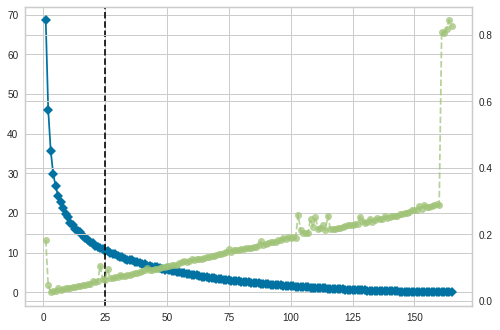

In [35]:
tracks_to_recommend = tracks.loc[pl1]
recommended, labels, centroids = rec.recommend_clusters(tracks_to_recommend)

In [36]:
for i,r in enumerate(recommended):
    print(f'Músicas pertecentes ao cluster {i+1}:')
    display(music_ids.loc[tracks_to_recommend[np.array(labels==i)].index])
    print(f'Recomendação para o cluster {i+1}:')
    display(r)

Músicas pertecentes ao cluster 1:


,name,artists
id,,
spotify:track:1D0w91Py3GRS6OHbQDpzDE,Foxy and the Weight of the World,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:27M2m1NzEmCkzb9kzTLqzT,Ready Lets Go,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5Gys2CeJwuTGlR8OsLYi29,Diving Station,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3BMOJrCCJqZedUwUS0m6NE,Open The Light,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 1:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:6eZPk7o4t6ntsyqoEDjGwJ,0.048775,Atonement,"{""(3EAHF3jdnHHdko5DBrhRUP,\""John Powell\"")"",""(...",0.405,0.131,0.1000,0.892,0.1390,0.580241,0.0414,0.579930
spotify:track:6YhTlOY8JMgm8jLdTemtuP,0.065796,Parabola,"{""(6UYAfofJdrj8oGM4Gcnq4A,\""Tool Tribute Band\...",0.351,0.183,0.1210,0.876,0.1690,0.578763,0.0398,0.634089
spotify:track:3zURZ1Mr8hNM7ROfIn1hwM,0.082428,Exploring The Island,"{""(0kZQLbj8h2SMVZHUJSbfBQ,\""Jason Graves\"")""}",0.451,0.177,0.0811,0.913,0.1110,0.550914,0.0302,0.597935
spotify:track:43zbJHRAvPLwzAIYVS8gps,0.088118,The Way We Win Matters,"{""(5Il8YjuVAWkWNH2xgjFMpF,\""Steve Jablonsky\"")""}",0.379,0.141,0.0999,0.902,0.0855,0.585093,0.0382,0.562585
spotify:track:4feEddQ9r7K5i1DI6BC85V,0.088435,The Fens of Sargath,"{""(5hgOjk7FGUwJvo1J3oDK9R,\""Midnight Syndicate...",0.383,0.149,0.1250,0.926,0.1830,0.523528,0.0363,0.551369


Músicas pertecentes ao cluster 2:


,name,artists
id,,
spotify:track:4xwoa2JvoOtAlSOdrQVw40,An Evening with Rthrtha,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1vaZfGdZhsoR1IYXGktDCn,Upmann,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:52atZArQ7K8oCQzYEv7YW1,Psychic Swelling,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:2GQStvWn2DHMUHv4nzOlw8,Dipsmack,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:2ImubT5sEfocjblQ2ssF0D,Braided Cellophane,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:2YxoC2dYOotjqt08dEifsc,Chromakey Dreamcoat,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3USwZDyAeJjCjeUMqnvHAg,Oscar See Through Red Eye,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5D7jl5qqynjNZZEiy4KQ2b,Hey Saturday Sun,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:31Wui18tjMUSmIig5fvf6o,Magnetic,"{""(4jd6GufdXsJXzwXXb0zX2T,\""Tabla Beat Science..."


Recomendação para o cluster 2:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:67M3MXzigwgK2iMU5dyIqe,0.049319,Bright Light,"{""(0aDiDIQbJrePa1QFZidEmy,Mokhov)""}",0.0943,0.529,0.787,0.903,0.1450,0.808311,0.0420,0.339962
spotify:track:38BShABhsfhWksmwbrq9IY,0.050618,Interlude II,"{""(6K3loJxbWoXzVycXOBKh7P,\""Mark de Clive-Lowe...",0.1050,0.495,0.759,0.889,0.1170,0.807125,0.0332,0.359959
spotify:track:1luwpeDvEPwi6XawDqTkt4,0.054516,All Alone,"{""(1kxc4wfA8JEm5D6xHTxXCZ,Gota)""}",0.0568,0.537,0.774,0.842,0.1200,0.804692,0.0294,0.359679
spotify:track:4lChJUaYql8mVBLWLpmBSh,0.061612,Slow Down,"{""(5tOiT7pdFoQN3hf2OWj2fv,\""Schwarz & Funk\"")""}",0.0735,0.532,0.757,0.851,0.0927,0.779400,0.0318,0.320037
spotify:track:2ablABzKjaWlvzpkjp4aVO,0.062728,Rebel Beans,"{""(2nUbg56ljfs5oXyB1UNiY8,Helvetia)""}",0.0701,0.491,0.790,0.893,0.1180,0.792031,0.0536,0.376468


Músicas pertecentes ao cluster 3:


,name,artists
id,,
spotify:track:2hHwyZ6yQO5l4PDupAPu17,Helium Tea,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:2hHwyZ6yQO5l4PDupAPu17,Helium Tea,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:15wtj7oUNjMlov6hYWTX10,Into The Rainbow Vein,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:6OzOsP5Ftn3osfuCvSxnYr,A Moment Of Clarity,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:2SlZLQTRyq0YMxhHqHIUwx,I Saw Drones,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:54IGiCAOFeISJAGZoHjtjf,Corsair,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:1H4Eiavp6smYJDIYQmo0vb,Wildlife Analysis,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5dm5vtne8lx8BPrVamK6S1,The Color Of The Fire,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3aqXL0g0eeZrS4Qlf7dV8O,Kaini Industries,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 3:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:73pvSNr6EyE4zfMWVylFA0,0.031445,Relic Uncovered,"{""(5hgOjk7FGUwJvo1J3oDK9R,\""Midnight Syndicate...",0.967,0.265,0.1010,0.915,0.148,0.512730,0.0459,0.294247
spotify:track:0217klJkz1tjoYYF7hKMaJ,0.044862,"Fantaisie Espagnole, KSS 19","{""(1huHshItOW19mvQYwwrRbq,\""Kaikhosru Sorabji\...",0.986,0.262,0.0894,0.918,0.132,0.534895,0.0379,0.308080
spotify:track:46j15jOxWI6e3jJanNbNIh,0.046667,"Piano Concerto No. 2 in B-Flat Major, Op. 19: ...","{""(2wOqMjp9TyABvtHdOSOTUS,\""Ludwig van Beethov...",0.974,0.268,0.0564,0.918,0.154,0.539485,0.0385,0.295395
spotify:track:2OXwIYI9D19PMOjdnqpWmk,0.049066,Harbor Neuroscience,"{""(5qlzaXu4riV8YLrL97cwyI,\""Mark Isham\"")""}",0.987,0.236,0.0850,0.908,0.136,0.529828,0.0425,0.310076
spotify:track:4PvATPb94iik3Ggz70WSDk,0.049288,"Waltz in D-Flat Major, Op.64, No.1 ""Valse Minute""","{""(7y97mc3bZRFXzT2szRM4L4,\""Frédéric Chopin\"")...",0.987,0.265,0.0933,0.885,0.158,0.515210,0.0322,0.313800


Músicas pertecentes ao cluster 4:


,name,artists
id,,
spotify:track:1gEZEUNmUjj0uJsE15qQxZ,Black Blizzard/Red Umbrella,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1QpUZ5yZzOr1HYBs7nt2DU,I Saw the Bright Shinies,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1OYWlGjzKl3IPJEWr0zjQD,Elq Milq,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1McBNvjKAwFUCE5xoEdXxA,Lemon Lime Face,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:6BskIiOgoHR7zvZ0pvYnY8,The Dark Forest Joggers,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:4PfmgV8iao0iq4PMiueeNE,Happy Melted City,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:1McBNvjKAwFUCE5xoEdXxA,Lemon Lime Face,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:4P65WnrUHAxktcPYbipVOz,Mockingbird Comes Calling For You,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:56e8Ac9LVRJf3SvVa9vVg0,Forever Heavy,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."


Recomendação para o cluster 4:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4UCbZ6smLpKwcjCo9xCzyD,0.062725,Flying High,"{""(1EpLpC0tbCla8knfhET78p,\""McCoy Tyner Trio\"")""}",0.671,0.486,0.749,0.808,0.165,0.816044,0.0392,0.519759
spotify:track:16NUOPzXGzCEyoLxoFc87E,0.073379,La Femme,"{""(5VTWoYYizcOY3uIKnxeCGI,\""La Femme\"")""}",0.694,0.494,0.679,0.800,0.129,0.820064,0.0496,0.479953
spotify:track:58Yy9luMC264M10gkUCRbT,0.084865,Waves,"{""(6BbqU3r1G2mwkRIfIbkCek,Bayonne)""}",0.781,0.527,0.731,0.802,0.176,0.813055,0.0443,0.445563
spotify:track:6klmQRMwixVFcjxUndqTp3,0.085032,Johnny Come Lately,"{""(3BG0nwVh3Gc7cuT4XdsLtt,\""Joe Henderson\"")""}",0.742,0.526,0.675,0.767,0.162,0.787025,0.0504,0.501466
spotify:track:4w2hFAVR64OqVDzbzpQPZB,0.088412,So Long Tonight,"{""(1MspPfENB9nzFGaagXmF7R,Lucero)""}",0.746,0.537,0.750,0.847,0.196,0.767494,0.0426,0.496310


Músicas pertecentes ao cluster 5:


,name,artists
id,,
spotify:track:2SJMm1mWgcy3pj2gMfwRiQ,Truck,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:16J9mdZAQOjcBPSTjkfV1F,Lollipopsichord,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:37i0ZCqSTN8wReTmhomxnB,All the Friends You Can Eat,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:6GguhgFkTXMexUyWrhWohy,Twin Of Myself (Original),"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:7bZmtfAmoSEChECHN2Wr5g,Melt Me,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:0XrX1hCniOflI5Omli6Jkc,Caterpillar House,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:3ROmYjCVAJeoqi5ozYFi6J,Father Sister Berzerker,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:28MRwtByj9g5p1XX4ym77e,Street Trash,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"


Recomendação para o cluster 5:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3RBA8x7YhMn8eCi5XWcT77,0.070834,Joe And Gina,"{""(0SV9HOx7egnyRQhmc8LakG,\""Stan Hubbs\"")""}",0.0715,0.350,0.789,0.0723,0.165,0.861236,0.0360,0.576258
spotify:track:39qeDVWdvAxGWYdnN9uGAH,0.074861,Puppy Gumgum,"{""(34O6ALtSTFh0OeY6PLGjqx,\""Sun Club\"")""}",0.0839,0.339,0.813,0.0943,0.137,0.848883,0.0567,0.497654
spotify:track:2bFuzVX8oL7ttLd7rJPfcx,0.081364,Chronicle of Heroes,"{""(4Kyb02r7dR3H1PH7pYkb8X,\""Epic Score\"")""}",0.0666,0.318,0.798,0.1770,0.142,0.835189,0.0590,0.519447
spotify:track:0wxRcmXOX4i9Q3orURnmEa,0.081762,Chlorine & Wine,"{""(3KdXhEwbqFHfNfSk7L9E87,Baroness)""}",0.0596,0.314,0.804,0.1490,0.126,0.840873,0.0587,0.504102
spotify:track:07tMRIRmq0oLKCbOdJO2eK,0.082457,Child,"{""(0vW8z9pZMGCcRtGPGtyqiB,\""The Maccabees\"")""}",0.0671,0.333,0.785,0.1720,0.135,0.851162,0.0357,0.573398


Músicas pertecentes ao cluster 6:


,name,artists
id,,
spotify:track:3FbMHj3mEEwp4hjpVJmnxt,The Touch from Within,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:504UFus8XxKzXZZAVnDRXo,You Could Feel The Sky,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:1GEKc8wS1qUP2hkpSeT0wt,Monster Hit,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"


Recomendação para o cluster 6:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:7nZeiPjTGB7aMEqLq2iTPG,0.077518,Track One,"{""(0JdGPxHeRGfOyZg3EHwp2g,\""Alex Wiley\"")""}",0.0171,0.522,0.424,0.462,0.136,0.754432,0.0492,0.439983
spotify:track:0w4ENmn145HA5v7wNys6QV,0.090726,Love Is Strange - Overdub Version,"{""(3wYyutjgII8LJVVOLrGI0D,\""Buddy Holly\"")""}",0.0364,0.509,0.477,0.505,0.149,0.724812,0.0273,0.435039
spotify:track:0RP7XWOUBJdxsJegD4n0Pu,0.091626,Breeze II,"{""(5Gy7hl4wnYEEotW721MXyk,\""Fungi Girls\"")""}",0.0692,0.498,0.449,0.436,0.116,0.724027,0.0354,0.489717
spotify:track:4PsOUd25CYuJQqjEf2xsrS,0.092041,Utah,"{""(1OlzK1kHcdTcduXcdXHYXn,Lucette)""}",0.0184,0.566,0.451,0.446,0.146,0.771560,0.0271,0.448215
spotify:track:3akSHd7uMBShzSkQoOQpmD,0.094615,Walking Through the Country,"{""(2IU5UBup85LmAXh5U36DeC,\""The Grass Roots\"")""}",0.0645,0.511,0.396,0.445,0.141,0.699382,0.0378,0.416218


Músicas pertecentes ao cluster 7:


,name,artists
id,,
spotify:track:6pxWghcPKRSjZPj8Ba9vpB,Satellite Anthem Icarus,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:2HHAxkrJbuWZ7JWdxYbsWO,Peacock Tail,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:7bgtelfoppWqHtwkQudvod,Julie And Candy,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:4ZX7QjwBqZTelll7to0d5S,Aquarius,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:0jWCjcVTmrg4WVBh4Cdwh3,Vapour Rumours,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"
spotify:track:2cfmjFK51sBubowSigw5f8,Shpongle Spores - 2017 Remaster,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"
spotify:track:0zgq3B4xHUPRYcnBBEVvqD,…And The Day Turned To Night,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"


Recomendação para o cluster 7:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1ofuJmzLA1F4hAFnDdg2bx,0.055672,Limbo,"{""(48pL8aYB6AeIEF5NQQjdbT,\""Film Noir\"")""}",0.0236,0.652,0.487,0.897,0.189,0.745899,0.0373,0.600243
spotify:track:5q7WUgLXbAOZTLtWN69qHZ,0.060293,Drunk in Love (Instrumental DJ Mix),"{""(1f5AogIDRDQUWLxZGQPXXq,\""Hip Hop Combo\"")""}",0.0273,0.597,0.508,0.899,0.190,0.736796,0.0323,0.559813
spotify:track:4xZNRIiWsgKZ51dHDvOfh1,0.066764,Worlds To Run (VIP Dub),"{""(13vr2QqzoWOWDyaAZDuEGO,\""Kenny Segal\"")""}",0.0420,0.635,0.484,0.857,0.242,0.746161,0.0311,0.572510
spotify:track:0FPI1yq6ohEQTHUcsYlwgA,0.067521,Walk Away,"{""(0wqWE1RGSbAyNsaLT3U640,\""The Ritz Club\"")""}",0.0793,0.590,0.491,0.850,0.164,0.755094,0.0549,0.608000
spotify:track:4oJAiDLVSunkr58PchiHSv,0.068694,Psychovision,"{""(1TY8JzETLheB4vm5QblKsF,\""Daniele Luppi\"")""}",0.0304,0.598,0.474,0.908,0.165,0.721301,0.0344,0.608396


Músicas pertecentes ao cluster 8:


,name,artists
id,,
spotify:track:3t2n91JYKy4oDgjIRCKHjI,Sherbet Head,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:2d9urYuH9914QkHZcNLIXF,Opening The Mouth,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 8:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:41pwaOBavDnFRbA09Ikdpr,0.150319,Crawlspace,"{""(7xP1csQv1peYwRcHfreMgz,\""Dead End Ranch\"")""}",0.684,0.211,0.549,0.941,0.345,0.581966,0.145,0.348322
spotify:track:0ohoSPFG1Kp7QEvhQlghdC,0.152908,Music and Sounds of the North Shore,"{""(2wdilDjBFjtfm30BczhsPa,\""Nature Sounds Arti...",0.754,0.160,0.333,0.923,0.343,0.530459,0.120,0.439823
spotify:track:12zBYwW08aswjPY6twBzbY,0.169010,Cat & Mouse,"{""(1tcgfoMTT1szjUeaikxRjA,\""Ryuichi Sakamoto\""...",0.689,0.278,0.374,0.874,0.311,0.645164,0.155,0.455720
spotify:track:6An55ksVnhlhChFM3VrdKE,0.177923,Search For Delicious,"{""(1R84VlXnFFULOsWWV8IrCQ,\""Panda Bear\"")""}",0.776,0.219,0.394,0.958,0.360,0.591254,0.310,0.321277
spotify:track:3K9ncwGP0LFASiOm9rZgzA,0.183762,Splitting,"{""(2bJwvgM8CXAKyYkTq7p1hO,Keyworth)"",""(6rCaJpT...",0.688,0.170,0.529,0.957,0.332,0.650247,0.105,0.493126


Músicas pertecentes ao cluster 9:


,name,artists
id,,
spotify:track:3KflFtXKKX61Ljf3TQqXln,Beware The Friendly Stranger,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:15QPuw3vRaZBc54iOWIrCM,A Is To B As B Is To C,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 9:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:034S9nlGkQLhy4HWJDtkAS,0.202815,Weather Report,"{""(1YrtUPrWcPfgdl9BaD9nhd,\""Khalil Fong\"")""}",0.913,0.455,0.466,0.000902,0.233,0.639357,0.579,0.302940
spotify:track:3bUXdF1621TZRHNNQP5qzU,0.215955,House Work - Live From The Laff House,"{""(3rHl3rSgCnHhOlVB87ZxyF,\""Kevin Hart\"")""}",0.940,0.449,0.381,0.000000,0.401,0.663617,0.653,0.298964
spotify:track:5xcZmXXQtScI0B97Qeipv1,0.219109,This Little Light of Mine,"{""(2wkz8hACugzAvF0voupg3H,Odetta)""}",0.876,0.460,0.399,0.000000,0.319,0.708948,0.675,0.361979
spotify:track:6RuSZZUnNp2K3zt3lmrzSE,0.224841,The Beginning,"{""(1xSSjJrKTO2ZNPU81uLtmI,\""Bliss n Eso\"")""}",0.951,0.410,0.361,0.007820,0.334,0.582490,0.566,0.373075
spotify:track:1nLtI3rCFS7fGOhf2hUvx3,0.225768,Intro To Amazing Grace - Live,"{""(0sD8Amms4kSxs5tBV4CUmR,\""Smokie Norful\"")""}",0.847,0.457,0.318,0.000000,0.295,0.649878,0.590,0.339254


Músicas pertecentes ao cluster 10:


,name,artists
id,,
spotify:track:6SGCuXA6JcJfeqFCHRl6CN,Marshmallow Window,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:5HSs48PwXeVLptLEJAxCDp,Royal Firecracker Teeth,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:5HSs48PwXeVLptLEJAxCDp,Royal Firecracker Teeth,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:6SGCuXA6JcJfeqFCHRl6CN,Marshmallow Window,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:23rh304BRyRNX2WZ9DLngn,The Afternoon Turns Pink,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:2Z0t4YcmGOQkxjJRi84kp2,When the Sun Grows on Your Tongue,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:6eKElHOBxn0TGFrU3gcCq5,What You Gonna Say To Me?,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:7IFLsGyxJUX4cCWauaWG6U,The Beach At Redpoint,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5bcFbghBC4q8ngXWn9yims,Biotech,"{""(4jd6GufdXsJXzwXXb0zX2T,\""Tabla Beat Science..."


Recomendação para o cluster 10:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0KAmFKd221KhFHHozPh9NW,0.092685,Sailors and Animals,"{""(77oD8X9qLXZhpbCjv53l5n,\""Mercury Rev\"")""}",0.443,0.440,0.933,0.844,0.297,0.863515,0.0431,0.420198
spotify:track:6MUeJyo2MKAB9tKWwtPAmA,0.093635,On My Own,"{""(0jTOyh4tUJWtIMDV73fcN4,\""Les Sexareenos\"")""}",0.496,0.428,0.973,0.865,0.272,0.814164,0.0448,0.509258
spotify:track:2p9K2fpVKRI99U6udpbEj6,0.094068,Chichita,"{""(3HFLs2Kw7HWE3UZUtLzIeS,\""Los Ecos\"")""}",0.440,0.437,0.969,0.826,0.314,0.829875,0.0873,0.463244
spotify:track:5nY8LtPFFRH0mIfBRx66S6,0.101901,I Sleep Alone,"{""(3p0vuGnsU3JN0ZVBLiJwmp,\""Dead Ghosts\"")""}",0.512,0.434,0.940,0.813,0.207,0.862807,0.0436,0.524291
spotify:track:4VykRVfEojT5vCCtFGFOBT,0.112493,Big Black Hole,"{""(14UQmxJzeKtmgYzJ1sEJdi,Oblivians)""}",0.422,0.391,0.832,0.864,0.259,0.828551,0.0626,0.478373


Músicas pertecentes ao cluster 11:


,name,artists
id,,
spotify:track:7wuE64ohnAThVcrUEyo0sV,Streaker (feat. Notrabel),"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)"",""(3UYripz5..."
spotify:track:5Y7hlVukaPuwUcahIzAzkl,Face Breakout,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:4Nl0mcNhE8M2qn71yJjwJA,Blow Your Heart,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:7LY0R33pPIFr0Y64VZC9Wo,Dawn Chorus,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 11:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:16o2DYA9CYVSk7TyhBljPy,0.064969,We Come in Pieces,"{""(7bBn6ywCFnU51qTvH6ZdIa,\""Ample Mammal\"")""}",0.005930,0.415,0.733,0.1730,0.740,0.821619,0.1130,0.440203
spotify:track:5A0tm1XCf8C3OOkJq7xu2x,0.094431,Death Of The Sun,"{""(14xDnik9GIQwU5yZLNp9j0,Gunns)""}",0.010400,0.325,0.731,0.1010,0.725,0.782404,0.0940,0.462648
spotify:track:6pNksvgLYC4A6QikWn3tZ4,0.096132,Lift,"{""(79a4DDvkxUJy73sCJqrC8q,JJD)"",""(69kFCyHDE14c...",0.009860,0.442,0.723,0.1090,0.683,0.839795,0.0556,0.460056
spotify:track:6HNX6VFzWLRdz8vzx73ZJt,0.097853,"50,000 Miles Beneath My Brain - Live at the Fi...","{""(7nkLRaWHImCvWGHdNGnhVE,\""Ten Years After\"")""}",0.002600,0.404,0.764,0.1490,0.672,0.765923,0.0739,0.488185
spotify:track:2KCcKuq3VIF1bk92FYl6UG,0.100482,I Hate You,"{""(2kPWIkNztu9BFXGOyp8uOC,Monks)""}",0.000126,0.469,0.806,0.0919,0.738,0.807295,0.0779,0.444775


Músicas pertecentes ao cluster 12:


,name,artists
id,,
spotify:track:4HlWk0lVYpbC2ztSA7nveK,Bees Bein' Strugglin',"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:4lUufWNXgdgJsFl5FCpUjQ,Ghost Moves,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:2IlL8ph6EbsEi8HOoyEWQF,Exploding Snowhorse,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:03GmiapZrVujkO2BwX945T,Lollpopsichord,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:7LdfKO6BWufPr8ItB9uMMz,84 Pontiac Dream,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3JZjPBwqL5F4PE55nm8iNV,1969,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5B5nloaA2UpNrjweosqVe3,Telephasic Workshop,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:4xmce2Et7muv5rjmjBQq83,Turquoise Hexagon Sun,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:7wq2C8M4qBpww8UGV89xwu,Behind Closed Eyelids,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"


Recomendação para o cluster 12:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:5G0POeFYCIbV3awVyXyBYM,0.050327,Psychic Hearts,"{""(1J4ACYB6yMqd79q3rjskqs,\""Thurston Moore\"")""}",0.005470,0.574,0.848,0.785,0.167,0.777629,0.0460,0.612420
spotify:track:6adMQSmpqsAV008B2XQbcJ,0.059605,The Bio-Terrorist Threat,"{""(0xI3PXMjV8dzC7Cvj5fYJB,\""Nathan Johnson\"")""}",0.004080,0.559,0.868,0.820,0.133,0.778815,0.0813,0.584234
spotify:track:4SoU64XpahSw7WFU0o3uvC,0.065014,Hardstyle Revolution - Showtek Remix,"{""(4qf5XXdaReYNKEqimVju5g,\""Abyss & Judge\"")"",...",0.028800,0.537,0.871,0.815,0.125,0.819602,0.0765,0.588111
spotify:track:4nWYaXFazQlEKZls0o4BIq,0.066844,Evilove (Psytrance Goa Fullon Hard Dance Mix) ...,"{""(0mLDMUZYF0kMqSBpp2XSdc,\""Psychedelic Mushro...",0.000087,0.545,0.873,0.803,0.122,0.789920,0.0584,0.623988
spotify:track:6chdgBe2l53LCViMWyWHsD,0.070279,Hellfire! (Cykophuk Remix),"{""(6bJ1p0mRb8VSJoSsWCtCiU,\""The Electric Hellf...",0.000015,0.555,0.875,0.822,0.162,0.772623,0.0452,0.580218


Músicas pertecentes ao cluster 13:


,name,artists
id,,
spotify:track:501SIhW9HgQODkAmrhp5zJ,Snow Tip Cap Mountain,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:0lcAGrKT4UBAikPUxq1Goa,Drippy Eye,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:4N5TTz87DyDV75aq2seaiE,Untitled Roadside Demo,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:5DxF534IkYlHggb8oyTyEI,Spitlord,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:3NFvPiE8u70nJymhP17Orx,Ataronchronon,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:6InkUffjcAOYPiX4BEAjrU,Constants Are Changing,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:6IBbvwR5G7bhGfhtBqPUDZ,Farewell Fire,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5LrPKZmACz0BVdWGU0ycxx,In The Annexe,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:193DxvYZR8xMzt0AujMrDU,The Smallest Weird Number,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 13:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2AxnA0x0xzXdh0Dv9kkufo,0.056790,A Mighty Fortress Is Our God,"{""(7zbq3gjHu4JAiMV7dWbUdv,\""David Nevue\"")""}",0.950,0.255,0.192,0.906,0.187,0.633350,0.0445,0.653650
spotify:track:48gzGGNiaTawmhN6Gkhmp9,0.059170,"Variations for Winds, Strings and Keyboards","{""(1aVONoJ0EM97BB26etc1vo,\""Steve Reich\"")"",""(...",0.964,0.232,0.203,0.893,0.187,0.596784,0.0385,0.606736
spotify:track:3tJr5AQcBbRFLCcTOGk14V,0.063392,My Belief - Original,"{""(0fauHpmSHwodVYIjTqOGHz,Yiruma)""}",0.990,0.221,0.147,0.887,0.165,0.625171,0.0322,0.608948
spotify:track:5GYJLvY6Xt6wrNCZu3K8JM,0.064746,Fresh Start,"{""(49j7cHDaqkF4vMiQ8QINxL,\""Jackie Child\"")""}",0.976,0.219,0.199,0.877,0.136,0.611894,0.0394,0.626781
spotify:track:1BDeuArYqzr3IKNpAVkNUh,0.067198,"12 Etudes, Op. 10: Etude No. 12 in C Minor, Op...","{""(7y97mc3bZRFXzT2szRM4L4,\""Frédéric Chopin\"")...",0.972,0.199,0.165,0.858,0.211,0.609014,0.0307,0.617896


Músicas pertecentes ao cluster 14:


,name,artists
id,,
spotify:track:3sbqLKpvorPRqKzJJ19ZZK,Loud Murmuring,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:0lAveUGBd27UoLnhbnSzgG,Good Complexion,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:6FNaIh3uWIFQ4aOaM4B8HP,Omen Classic,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:6N759vFYolaNbbdd4As2Wi,Sixtyten,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:2XQSgmtEY2titXhfY414dy,Roygbiv,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:5SGNNAQg2hEfOZItKVFklK,Pete Standing Alone,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:6G4Iu30Hp9SHWQ1k2Fow7i,Happy Cycling,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:750rTU2yZA8Q7jCKvtjl6m,Miss Teardrop,"{""(3E6Tbv49KoKnCoGqHJHQGx,\""Felix Laband\"")""}"
spotify:track:2TuLQAgHf21IciocfEn6sv,Big Brother,"{""(4jd6GufdXsJXzwXXb0zX2T,\""Tabla Beat Science..."


Recomendação para o cluster 14:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3a26mtWfGGQn1R3Kv6nZlm,0.070245,Mama Said Knock You Out - Instrumental,"{""(6YEePswCcCZZRYcQfT2Ypx,\""Syndicate Sound La...",0.02770,0.765,0.561,0.890,0.1450,0.745036,0.122,0.409585
spotify:track:5ZpYMS7b4yuwJ7wNtDg7Z9,0.072612,Zulu Whisky Hotel - 2CV Remix,"{""(65OBGjnEk7QhI21be3JUIl,\""Tronik Youth\"")""}",0.02560,0.715,0.616,0.857,0.0900,0.766031,0.092,0.432134
spotify:track:5SQHJButGcL7DifrAOPvVJ,0.073300,One Less Problem (Instrumental),"{""(2ZWVwayY6qBnOGIlqr32cj,\""You Without Me\"")""}",0.00432,0.698,0.600,0.868,0.0846,0.795204,0.110,0.411889
spotify:track:3qh9YSviBIPUB3ONZuF5dL,0.078279,Vuelo Nocturno,"{""(6PuOeFpvcL6TYcRmEJKbdw,Umoja)""}",0.05900,0.707,0.637,0.849,0.1090,0.734794,0.128,0.444223
spotify:track:2Pbte5GQmqA2IdMY7AXt6P,0.080757,Inside Out,"{""(61iqbk65wVKqPP89zO03qz,\""Eric B\"")""}",0.04060,0.719,0.629,0.904,0.1350,0.733515,0.135,0.384260


Músicas pertecentes ao cluster 15:


,name,artists
id,,
spotify:track:3RjTS80WoMLmy7QDQlVjo0,"It Hurts to Shoot Lazers from Your Fingers, Bu...","{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:0nRe4ZWzbiFjJIJFEk1u3F,Tears From The Compound Eye,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 15:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:08FEO0NdfXDIpRooYMgdB4,0.123337,"Live At the ICA, London 40:07","{""(6EoXpSE9sRNGaingbSDcNB,\""BJ Nilsen\"")""}",0.000052,0.0620,0.194,0.916,0.1070,0.607119,0.0463,0.204439
spotify:track:36XiQvZD8xLvgHogVf2mjn,0.125076,Floating Textures,"{""(3dVEdoYQ18UPwHmOllDyT8,Gulan)""}",0.026600,0.0593,0.148,0.943,0.0914,0.660752,0.0466,0.217067
spotify:track:0FUqN0GGASJMWH4eceJKPl,0.125460,Seeing You Off The Edges,"{""(4QK3YJ6hzJdhJHE9q7kbVV,Eluvium)""}",0.068300,0.0570,0.212,0.933,0.1120,0.709363,0.0410,0.183110
spotify:track:2m82lmAWKgQBWNUgGne8Yx,0.139838,Meditación Profunda 111,"{""(7zwiFdY90oXzLh1Wz22oEq,\""Meditation Music Z...",0.010200,0.2180,0.163,0.891,0.0920,0.620889,0.0359,0.180345
spotify:track:0POyYmFObLm3GTYy2PdjJf,0.142021,Tastes Like Blood,"{""(60Ob6q8BCjykLBKuF5aroP,\""Pinkish Black\"")""}",0.004450,0.0887,0.191,0.936,0.0844,0.644841,0.0437,0.260014


Músicas pertecentes ao cluster 16:


,name,artists
id,,
spotify:track:2e3md01ACPcn56X6mN5IFe,Dandelion,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 16:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1R9L3LMnOGUmzo4xY2kKY7,0.097650,Ты скажи,"{""(71hfS676pfxtjY7PpO9l6P,\""Vladimir Presnyako...",0.569,0.201,0.206,0.009100,0.348,0.645318,0.0327,0.277326
spotify:track:1MM1iJkzdeI9UoNWx20To0,0.099758,Lee Shore,"{""(59zdhVoWxSoHMc74n098Re,\""David Crosby\"")"",""...",0.564,0.344,0.181,0.000000,0.367,0.616746,0.0983,0.294459
spotify:track:3QdwF3CTgdbskDCvrBl3ic,0.101802,The Birth - Journey to the Light Part 2,"{""(6R1T5YklzC9OFugGt8RwOD,\""Cloud Cult\"")""}",0.510,0.193,0.223,0.034200,0.337,0.615960,0.0385,0.245849
spotify:track:4xhjstMvP7t8Lz0DwMhtmX,0.110358,Delam,"{""(421vyBBkhgRAOz4cYPvrZJ,Hiatus)"",""(1u4niqiOJ...",0.549,0.346,0.215,0.000002,0.366,0.663155,0.0500,0.305156
spotify:track:6aE31DneYAjPg4L7X1ccaE,0.111981,El Día Que Me Quieras,"{""(3Ker27Wbb9OcUHGs54JIAz,\""Los Panchos\"")"",""(...",0.550,0.284,0.225,0.000000,0.360,0.673952,0.0360,0.332705


Músicas pertecentes ao cluster 17:


,name,artists
id,,
spotify:track:10fcilqlC68N33eWF3rHa1,Magic Window,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 17:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1hut1H6NU9CMwX45IglEQD,0.0,The Most Important Track on the Album,"{""(6PWRJs1FosHp8Cqx0Nmswj,Astronautalis)""}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spotify:track:64gQPkGGRp45yBS7UeHCUr,0.0,Minut Ćutanja,"{""(08HRN7hYxMxJ4BOMP0TJK6,Marčelo)""}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spotify:track:193O4vZOZvdx7vrfZpfs37,0.0,Hello,"{""(4dpARuHxo51G3z768sgnrY,Adele)""}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spotify:track:71it7o2wPFJ7EvSzZ6pQu2,0.0,Turn Blue,"{""(7mnBLXK823vNxN3UWB7Gfz,\""The Black Keys\"")""}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
spotify:track:3LaeZ7Gusut4URA7h2HB3G,0.0,This Ole House,"{""(6ZjFtWeHP9XN7FeKSUe80S,\""Bing Crosby\"")"",""(...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Músicas pertecentes ao cluster 18:


,name,artists
id,,
spotify:track:18bq32DoxgOLSoWW00L029,Queen,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1nUTyLh3Ct8IOM3YB4QBia,Energy Warning,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:0zW6xwG3WfPv2WFAj6NUC9,One Very Important Thought,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:07waa43vJVgJOjSnSmuOyE,Radio Right Now,"{""(3E6Tbv49KoKnCoGqHJHQGx,\""Felix Laband\"")""}"
spotify:track:2IKkBnCYNEUptUKTXiqEFS,Minka,"{""(3E6Tbv49KoKnCoGqHJHQGx,\""Felix Laband\"")""}"


Recomendação para o cluster 18:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1lhWv35SFtzKF6VuhKl5LF,0.072325,Oh Quiet Night,"{""(42s4jW2I5XDUzAUfkA5uah,\""Kieran Kelly\"")"",""...",0.875,0.431,0.321,0.316,0.148,0.685689,0.0344,0.379892
spotify:track:0GrTw9nip3WaT3rZlojT8z,0.081097,Samba Do Aviao,"{""(0nPijYv2uVkfstvYBZ7QnZ,Morelenbaum2)"",""(1tc...",0.858,0.454,0.306,0.283,0.102,0.646350,0.0412,0.384624
spotify:track:0v7GvzUN0t8fi81nKcAQ1p,0.081745,De Stijl,"{""(2k91aXkeSCPtrFGQzvIgu3,\""Louis Andriessen\""...",0.906,0.387,0.358,0.244,0.111,0.668269,0.0542,0.359883
spotify:track:5dBOFZJ6UzGUpSQ6eOGkun,0.082251,"Sonata III in G-Moll, Op. 2, BuxWV 261: Sonata...","{""(2YfFYZnshSzgfLsKZMM4VL,\""Dietrich Buxtehude...",0.891,0.373,0.320,0.314,0.110,0.678696,0.0404,0.367931
spotify:track:01c1iCUxte3aQjNLlXc5Fb,0.093232,"Violin Concerto in E Minor, Op. 64: III. Alleg...","{""(6MF58APd3YV72Ln2eVg710,\""Felix Mendelssohn\...",0.915,0.366,0.277,0.280,0.145,0.674553,0.0472,0.336285


Músicas pertecentes ao cluster 19:


,name,artists
id,,
spotify:track:1HvA9cxsU1Wdv9ROW6gBM3,Vanishing Lessons,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1BDGxgDOjjFbX6012oAj1l,All the Friends You Can Eat (Original),"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:3vBJYnujT3yxLjLEG1jtDS,Music Is Math,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:0aiJjUQffDoOTntvqDlicF,Alpha And Omega,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:1k5q5ci7RH7KJJIAEunX7G,Shpongle Falls - 2017 Remaster,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"
spotify:track:7APHIpKi9GO7Xe4RotrDgY,Secret Channel,"{""(4jd6GufdXsJXzwXXb0zX2T,\""Tabla Beat Science..."


Recomendação para o cluster 19:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4N4yFLmC3Uj4SbviGJBGfy,0.052831,La Manouche,"{""(64oD1nmr26PzBAecbxdBzt,\""Angelo DeBarre\"")""...",0.195,0.482,0.806,0.906,0.678,0.807680,0.0466,0.539272
spotify:track:4oiXHvfIiBLK1eRLQHGvR8,0.077907,Sheets,"{""(4NzbUsYzmB8zD0GhdP3uZG,\""Critters Buggin\"")""}",0.174,0.436,0.791,0.932,0.708,0.758437,0.0694,0.570518
spotify:track:0jdqNlbsc2uUxGoRpJl77Q,0.091945,Pillars,"{""(2lZkXWxkZsZzBocxMjN1or,\""Sunny Day Real Est...",0.130,0.455,0.766,0.886,0.726,0.780463,0.0476,0.509939
spotify:track:0k9IvNXFFIHxoNWD8A5gpg,0.093843,Future Holds,"{""(74yueOpxONIcPCjGyF84jG,\""Tom Day\"")""}",0.139,0.483,0.737,0.922,0.654,0.796189,0.0287,0.519999
spotify:track:3A2cUmOFaynU4B5svsGE5V,0.097292,Sixteen,"{""(33EUXrFKGjpUSGacqEHhU4,\""Iggy Pop\"")""}",0.190,0.491,0.872,0.888,0.690,0.784668,0.0687,0.499258


Músicas pertecentes ao cluster 20:


,name,artists
id,,
spotify:track:4qpq8AX6XEaQLJvgPsbztB,Mmaj,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:49ZCrnH09OPQfy0JAFYJwS,Windshield Smasher,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:0qN8cB9d6esHuqjErKDrfv,We Are the Pagans,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:33z3z4ZGsYCZDb06AR0m2J,Old Yes,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:3MhAeSs2a5c0f9QoQMfbUQ,Jump into My Mouth and Breathe the Stardust,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:7nW46ALQszzBV5R4yZ64cD,Sun Lips,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:0Bo0caGIgLyxVMLLF4LCI7,Spinning Cotton Candy in a Shack Made of Shingles,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:56El1ZJMinSb9SgxuxRDQj,Eruption (Gonna Get My Hair Cut at the End of ...,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:2f6lhIMyPRh1oiMoxtq1ls,Lipstick Destroyer,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"


Recomendação para o cluster 20:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2ypXvrOqKTaBTsKjpX8jxZ,0.065082,It Really Doesn't Matter,"{""(7jefIIksOi1EazgRTfW2Pk,\""Electric Light Orc...",0.374,0.540,0.742,0.0828,0.180,0.839194,0.0270,0.433271
spotify:track:2iJXVBYPxlQYKLN2bJurs4,0.066935,Hands 2 Hold You Down,"{""(64AV09dDdCGBGv11QlGOJN,\""White Ring\"")""}",0.363,0.510,0.702,0.0611,0.132,0.828505,0.0414,0.499866
spotify:track:4jJzFJYKrf555eyb8nmKMe,0.067945,The Lochaber Badger/ The Glass of Beer/ The Bi...,"{""(0ezue86UmGPlFGn2tN2XVL,Sheena)""}",0.358,0.485,0.731,0.1080,0.181,0.826194,0.0294,0.459980
spotify:track:7HT9YhcKzY0s6SAxRCvhfO,0.074127,Our Life,"{""(6OSOjC1W6jRkFKKS35TnkK,\""Funker Vogt\"")""}",0.355,0.581,0.733,0.1210,0.130,0.801642,0.0421,0.503890
spotify:track:0mNIdZsBnayq6nC5ZlzISl,0.075326,Space Invades My Mind,"{""(0RxWnw4aoWwxXsC2cdCj4c,\""Maja Francis\"")"",""...",0.341,0.580,0.789,0.0870,0.161,0.830553,0.0447,0.472269


Músicas pertecentes ao cluster 21:


,name,artists
id,,
spotify:track:03zv0Znm7bA7XzWMZ1lEKO,An Eagle In Your Mind,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:1PWBiyJfQRjLfum9rVtKQa,Triangles & Rhombuses,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3Jp9ys8LTCzv9jPe0t8fHB,Rue The Whirl,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:0mfHgKTeqN8hcgOlAEHLQc,Smokes Quantity,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 21:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:5hqeuzuUzg4smCmMp41vbf,0.084306,SWASAME - GUITAR (FILM : THENALI),"{""(1lXpZ62En7Yf9QZr8KgHHD,\""L. Ramesh\"")""}",0.312,0.760,0.431,0.816,0.123,0.694484,0.0820,0.364095
spotify:track:0M6DxsCi7CtgA4JGG5lVrB,0.085458,Warm Water (Spa Music),"{""(47qvoNT3RnfJMN28nrsWT6,\""Spa Smooth Jazz Re...",0.289,0.761,0.400,0.870,0.116,0.708301,0.0702,0.380424
spotify:track:3jGSTtYlinBhlKqK2fK67G,0.085458,Trompette Magique (Hommage à Arturo Sandoval),"{""(7I4k8lhED0kNnxJgR4BCsS,trompette)""}",0.289,0.761,0.400,0.870,0.116,0.708301,0.0702,0.380424
spotify:track:5WwMIhnrPDa7dUHCmeyqJv,0.088370,Get Off the Bus,"{""(2OVqg3lxC8ZIf0vHcEqaCf,\""Cliff Martinez\"")""}",0.220,0.796,0.393,0.839,0.107,0.629530,0.1010,0.400109
spotify:track:02umqGfVuciStkowBRfw19,0.091303,Licorice,"{""(3PcMolaGsh2nryvBR2sQOS,Fourplay)""}",0.267,0.767,0.367,0.790,0.110,0.711381,0.0499,0.364155


Músicas pertecentes ao cluster 22:


,name,artists
id,,
spotify:track:5tjxCt5zM94DzJmnwbzJWW,Untitled Roadside Demo (Original),"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:3MtXPqKTTeDduI24TNveKF,Gyroscope,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3VcH4AZzVtUtHdz5jjjuT5,The Devil Is In The Details,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"


Recomendação para o cluster 22:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0VAWZO7BAC1Q1Veon1odBD,0.098628,Donkey Kong,"{""(1O3ZOjqFLEnbpZexcRjocn,RJD2)""}",0.839,0.654,0.619,0.876,0.679,0.716988,0.1400,0.377444
spotify:track:0Tt4qRsIh0MnXY0LtVyXEx,0.124714,Tu Cheez Barhy Hai Mast Mast Neha Kakkar and M...,"{""(5f4QpKfy7ptCHwTqspnSJI,\""Neha Kakkar\"")"",""(...",0.896,0.719,0.607,0.855,0.719,0.756219,0.1300,0.380268
spotify:track:2LYsGmL9cXM7BipnVwv0dw,0.124911,Steamboat Stomp,"{""(5GHLXPkq5y7bu1BlLQ5hvO,\""Jelly Roll Morton ...",0.823,0.683,0.561,0.871,0.601,0.785638,0.1170,0.491458
spotify:track:2i4LZ09iKmpub0SD1P5GUv,0.129753,Stick Out Your Can,"{""(4o2zkCpWF0zLf7NNpm7ZJM,\""Sharkey Bonano\"")""}",0.902,0.630,0.665,0.938,0.677,0.746207,0.1420,0.477261
spotify:track:0WUwuD6UX3wdk2Yw7jsUVF,0.149939,Topsy,"{""(0WdDpEeDIDmtYh5sqRrdI6,\""Charlie Christian\...",0.847,0.753,0.596,0.870,0.614,0.684857,0.0482,0.442931


Músicas pertecentes ao cluster 23:


,name,artists
id,,
spotify:track:6YjSzglY5Ah97FS2ERmQ0K,Copying Soup Onto Sexy Birdy,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:6sAYglztS3ZdbwTLdd23F2,Beds,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:08RIreNwkBWvZH7hyZclca,Another Place,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:0pMsXU8cburydeH1HSaIga,Moody Day,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:4eUKYcFTt9laG3tArjNq19,Changing You All,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:67El5pTYSZtuhFHky0dsNg,Wall of Gum,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:1aA6xdz9RguXCH0aylKHL7,Video Warning Attempts,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:3htO9aATRyGh3SC72v91hW,Slow This Bird Down,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:6V4nFLl9m00qZOmY1coV8b,Whistling In Tongues,"{""(3E6Tbv49KoKnCoGqHJHQGx,\""Felix Laband\"")""}"


Recomendação para o cluster 23:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2BSrIRnO3q6f521XqZWg0R,0.053876,National Emblem,"{""(3wtPhna5CKdqEjfNoFRMgC,\""USAF Heritage of A...",0.845,0.595,0.446,0.876,0.174,0.738983,0.0383,0.486681
spotify:track:3YOJZelIGRsylpMFPeTdnr,0.055632,The Sweet Sunny South,"{""(3QDaXfnxfQqqJQK5lSdjLN,\""Jerry Garcia\"")"",""...",0.884,0.620,0.414,0.867,0.221,0.754417,0.0358,0.473965
spotify:track:0NRvEMCsaHlp1JbWyghwCN,0.064498,Zapateado,"{""(3YhblKexMBqr3EMWDlQ5C8,\""Pepe Martínez\"")""}",0.920,0.593,0.457,0.880,0.197,0.781079,0.0657,0.468228
spotify:track:5cHjNySGWCGhKcNGKp7xyB,0.064757,Beaumont Rag,"{""(4rAgFKtlTr66ic18YZZyF1,\""Woody Guthrie\"")""}",0.834,0.599,0.482,0.826,0.200,0.753616,0.0602,0.485129
spotify:track:1sd34IjmIlLQS4tKM9QPJJ,0.070093,Berbère,"{""(7nFb95Ufz3MkdXP4bnlSES,\""Henri Texier\"")"",""...",0.845,0.594,0.431,0.894,0.181,0.760593,0.0356,0.442335


Músicas pertecentes ao cluster 24:


,name,artists
id,,
spotify:track:50LUayIoyHCMT3IYHdoIUO,Spiracle,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:5UoCPM4Kje5O1LFLVxkLLx,Untitled Hidden Track,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:5UoCPM4Kje5O1LFLVxkLLx,Untitled Hidden Track,"{""(4UHzJP2iKVf0RhKIv7ZE2l,\""Black Moth Super R..."
spotify:track:3Kp8EUf583LozpfteIgrJD,Beast Sting,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:0LX3YePG8zfDvcfYVcO2nH,Divine Moments of Truth - 2017 Remaster,"{""(0m5XJwKGYyUjd3VMfcINCQ,Shpongle)""}"


Recomendação para o cluster 24:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2UC3Tc7QCfjsvx97RfcVKP,0.103297,Opening Movie,"{""(58RrZSfiTZiUgjNvWO7vCt,\""TADAYOSHI MAKINO\"")""}",0.309,0.289,0.689,0.588,0.319,0.802150,0.0520,0.339242
spotify:track:0EuMJmh0BDoHJq44RhRQXP,0.117305,The Owl In Daylight,"{""(3H6yIZ1GLpc1WV51iuyZgp,\""Secret Chiefs 3\"")""}",0.206,0.273,0.727,0.567,0.267,0.813271,0.0416,0.328049
spotify:track:0D6sB55ghk8IOOtoCoG83Z,0.117472,Low Light,"{""(1RKPwhhogIthYoS8obEv65,\""The Soundcarriers\...",0.237,0.289,0.735,0.561,0.209,0.827087,0.0574,0.327785
spotify:track:7qtpPSLeZMGv0vrCZu5kxu,0.121431,Love of My Life (feat. Dave Matthews & Carter ...,"{""(6GI52t8N5F02MxU0g5U69P,Santana)"",""(13vQloYd...",0.322,0.397,0.773,0.553,0.270,0.832817,0.0456,0.372611
spotify:track:1NW7ebRb58nfrH4ygD2bYp,0.123441,Seven Zed Heaven,"{""(3s6o8vxtYJ1utkWl8EXxUp,\""Nels Cline\"")""}",0.251,0.306,0.780,0.571,0.208,0.771314,0.0650,0.345878


Músicas pertecentes ao cluster 25:


,name,artists
id,,
spotify:track:2MMwW5Saz4R0NiTFIdOjqW,Runite Castles,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:7eTTy7ZkiiqqlA3xUP5VMM,Tony Face,"{""(7EFRvnUHNLWOYVPg8AuI7o,\""The Octopus Projec..."
spotify:track:1MJeTp316OwWichf3CqWFX,Creaming for Beginners,"{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:79zxM1vzggB7ySfgMfDfSI,"Pool City, McKnight Road","{""(3ikKyCOrsMeANi0d5u8BCR,TOBACCO)""}"
spotify:track:4Y2W4zKa3q72ztbkA0r8Va,Dayvan Cowboy,"{""(2VAvhf61GgLYmC6C8anyX1,\""Boards of Canada\"")""}"
spotify:track:3JNgPVFDCAbYsz6lO1mxnL,Dirty Nightgown,"{""(3E6Tbv49KoKnCoGqHJHQGx,\""Felix Laband\"")""}"
spotify:track:7o5T4rgg36IDuIdKBCJVyw,Black Shoes,"{""(3E6Tbv49KoKnCoGqHJHQGx,\""Felix Laband\"")""}"


Recomendação para o cluster 25:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0RNB5q7TqFi6LWYmbYRLdM,0.057483,Vast Expanse,"{""(6kAJ3c9QA35wGowhDQeaya,Stillhead)""}",0.338,0.382,0.541,0.865,0.0746,0.758160,0.0393,0.655974
spotify:track:4LLo3ilQejeSRcRV2m8haO,0.063841,First Wave,"{""(3TsQ4RsUrs3pqO1hvgTCbb,Trocadero)""}",0.360,0.363,0.462,0.833,0.0944,0.772531,0.0315,0.640301
spotify:track:128kJHT8ITdJNnRaLJ4RXY,0.065716,"Hamlet#2 - être ou ne pas être, la question es...","{""(2vCtZAr1ED3QG73cwLqNUz,\""Robert Le Magnifiq...",0.307,0.384,0.508,0.856,0.0951,0.769573,0.0293,0.639745
spotify:track:0d0PFAx4eNMqNxFbsxdlYr,0.069163,Driving Song - Mono,"{""(6w6z8m4WXX7Tub4Rb6Lu7R,\""Jethro Tull\"")""}",0.370,0.394,0.562,0.835,0.1090,0.745529,0.0711,0.606708
spotify:track:28HlATDveaOOBmAzwrA7Xi,0.070204,Latinia,"{""(7CkD6EhsfLIn8UMhw9QsPf,\""The Centurians\"")""}",0.356,0.382,0.503,0.846,0.0932,0.716418,0.0385,0.653866


Quantidade de clusters: 3
Músicas pertecentes ao cluster 1:


,name,artists
id,,
spotify:track:1jdNcAD8Ir58RlsdGjJJdx,Ho Hey,"{""(16oZKvXb6WkQlVAjwo2Wbg,\""The Lumineers\"")""}"
spotify:track:4T6HLdP6OcAtqC6tGnQelG,Everything,"{""(1GxkXlMwML1oSg5eLPiAz3,\""Michael Bublé\"")""}"
spotify:track:1q74TesvRCIo5RvJM5B84F,She Is Love,"{""(2PCUhxD40qlMqsKHjTZD2e,Parachute)""}"


Recomendação para o cluster 1:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:67vbITI4lgat57x6Vg3u6k,0.036248,Gon' Lay You Down,"{""(7mpt5x0KHNwg6xHH7UTVk0,\""Wink Burcham\"")""}",0.610,0.664,0.449,0.000001,0.0979,0.785469,0.0486,0.446155
spotify:track:44xkwX1tdJ1cQI8SeMHN4b,0.040320,Walking in Memphis,"{""(2WHCmc8F47jv4YBTzZ7QoH,\""The Madison Letter...",0.581,0.644,0.456,0.000000,0.1010,0.809374,0.0485,0.459524
spotify:track:5OuQIkrpRNUP4BJfVFEV20,0.041629,Shiny Stockings,"{""(0JGC4vZOElU7fbDpkY136l,\""André Holst\"")"",""(...",0.618,0.662,0.442,0.000000,0.1110,0.793401,0.0386,0.466440
spotify:track:57pUHpCltt09b5w1W6m9qb,0.042076,最近,"{""(7ya3wFqG9X35S7L7XSrE2i,\""Sam Lee\"")""}",0.590,0.664,0.432,0.000000,0.1390,0.810098,0.0328,0.455540
spotify:track:4l1pgeDNsf5qHSByhTXZxP,0.043032,Good And Gone,"{""(7tNLRmiAN8hpmFrbIHiHsy,\""Patty Griffin\"")""}",0.588,0.662,0.459,0.000612,0.1160,0.781218,0.0326,0.443911


Músicas pertecentes ao cluster 2:


,name,artists
id,,
spotify:track:5GBWQszdw6PtAN0Negzut6,Can't Help Falling In Love - Recorded Live at ...,"{""(2vm8GdHyrJh2O2MfbQFYG0,\""Ingrid Michaelson\..."
spotify:track:7rPLZ8Krm6CZIbraFUlnWZ,Make You Feel My Love,"{""(4dpARuHxo51G3z768sgnrY,Adele)""}"
spotify:track:3ZMv9EzGoteNi5Qnx0KpEO,Skinny Love,"{""(4LEiUm1SRbFMgfqnQTwUbQ,\""Bon Iver\"")""}"


Recomendação para o cluster 2:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:7DGOev40woewThrBvZLKlC,0.026162,The Christmas Song,"{""(5zeCSgiRyezbfLiGOpKAsR,\""Tyrone Wells\"")""}",0.884,0.409,0.202,0.000000,0.107,0.738921,0.0384,0.292579
spotify:track:7um4GtcqRKIMnjb33cUc80,0.026798,All The Way,"{""(6WxegST7d2jCYjq7SR8Bds,\""Kat Edmonson\"")""}",0.897,0.372,0.196,0.000003,0.115,0.752445,0.0338,0.309592
spotify:track:3cBm4sXBIkcCMhwfcQ1PU3,0.028970,Confessions of an Honest Heart,"{""(29hPc6EdrO66VjZkAp7SWF,\""Jonathan Shockley\...",0.898,0.391,0.198,0.000000,0.101,0.747763,0.0392,0.317853
spotify:track:2PabSwv028L8tq3oGyvWpT,0.029560,Before The Throne Of God Above,"{""(5dZiRoY9Vpp6qrxqXNRwPE,Selah)""}",0.898,0.388,0.208,0.000002,0.111,0.754771,0.0275,0.315260
spotify:track:4ZOBWfhgzBLMKnJf1UDWxO,0.030238,Fifty Years From Now,"{""(75hRRIdYqw91RAKXyfZ4LD,\""Andy Denton\"")""}",0.892,0.412,0.202,0.000001,0.107,0.746623,0.0312,0.304124


Músicas pertecentes ao cluster 3:


,name,artists
id,,
spotify:track:4eYaDRhiL5iesFp2EuoODr,A Thousand Years,"{""(0jW6R8CVyVohuUJVcuweDI,\""The Piano Guys\"")""}"


Recomendação para o cluster 3:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2fCGBfL84TKN3UcHWz9Fom,0.040822,"Symphony No.35 In D, K.385 ""Haffner"": 1. Alleg...","{""(4NJhFmfw43RLBLjQvxDuRS,\""Wolfgang Amadeus M...",0.976,0.234,0.207,0.919,0.0782,0.695316,0.0335,0.617100
spotify:track:69FSeWCNH68lrziC3pkPbq,0.047164,Les Miserables - Drama Edit,"{""(17oBhyzDn8Zbtk4iwe12eE,\""Nikos Vangelis\"")""}",0.995,0.241,0.188,0.872,0.1090,0.726861,0.0348,0.638633
spotify:track:2vSMS3HrMTmv35R2oVQF5C,0.051924,Here In The Moment,"{""(7Ck0Rg37X2S60WdG9Wxv6f,\""Coty Sloan\"")""}",0.989,0.225,0.208,0.913,0.1170,0.748933,0.0346,0.622284
spotify:track:6KUHaO0zLDXLPKJ163fAIP,0.059856,"Jesus, Name Above All Names / I Will Sing of M...","{""(27IiF5ZcKgfYQE0ZXOm1Sy,\""Great Worship Song...",0.985,0.256,0.219,0.887,0.1230,0.680237,0.0336,0.631661
spotify:track:2IXEgkflgpiJY2n9tt4tjD,0.060643,Skyline To,"{""(1PwWIhUCp0622pmOLErpim,\""Blond Piano\"")""}",0.969,0.265,0.234,0.892,0.1100,0.701508,0.0427,0.599079


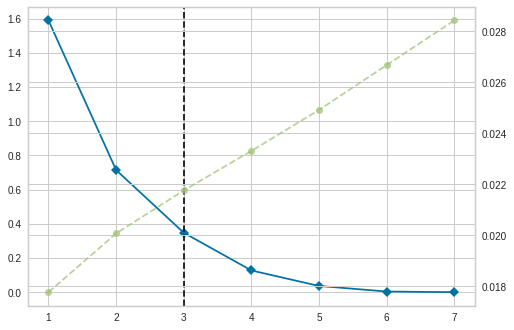

In [41]:
tracks_to_recommend = tracks.loc[pl2]
recommended, labels, centroids = rec.recommend_clusters(tracks_to_recommend)
print('Quantidade de clusters:', len(centroids))
for i,r in enumerate(recommended):
    print(f'Músicas pertecentes ao cluster {i+1}:')
    display(music_ids.loc[tracks_to_recommend[np.array(labels==i)].index])
    print(f'Recomendação para o cluster {i+1}:')
    display(r)

In [42]:
pl3 = dataset.read_playlist_formatted(223)['track_uri']

Carregando dados da slice 0-999


/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (117) found smaller than n_clusters (118). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (117) found smaller than n_clusters (119). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
/home/paulo/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:330: ConvergenceWarning: Number of distinct clusters (117) found smaller than n_clusters (120). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)


Quantidade de clusters: 17
Músicas pertecentes ao cluster 1:


,name,artists
id,,
spotify:track:5ihS6UUlyQAfmp48eSkxuQ,Landslide,"{""(08GQAI4eElDnROBrJRGE0X,\""Fleetwood Mac\"")""}"
spotify:track:5y788ya4NvwhBznoDIcXwK,The Sound of Silence - Acoustic Version,"{""(70cRZdQywnSFp9pnc2WTCE,\""Simon & Garfunkel\..."
spotify:track:17VegeBoHvMlIByrdu64KR,Your Song,"{""(3PhoLpVuITZKcymswpck5b,\""Elton John\"")""}"
spotify:track:4JdEh0vbCChtjGwQpHxdeF,Somewhere over the Rainbow,"{""(3ulXcJHsniZBycOD3Tic9T,\""The Ukulele Boys\"")""}"
spotify:track:1KkwByi6c9dFFmUTcgMODw,"Raindrops Keep Fallin' On My Head - From ""Butc...","{""(0uUNzXylqsZdmFDwdxaP1V,\""B.J. Thomas\"")""}"
spotify:track:1pmYAWY7Kwaj84U3xZxLML,Time In A Bottle,"{""(1R6Hx1tJ2VOUyodEpC12xM,\""Jim Croce\"")""}"


Recomendação para o cluster 1:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:37hQfblfaeGHygMRtzPiuB,0.019308,Once Upon A Dream,"{""(1x7QlgJUVrLv1SSyeknnJq,Laika)""}",0.856,0.537,0.247,0.002880,0.1100,0.688169,0.0298,0.527411
spotify:track:6uPDscQhyUZ3FGXPEWPd8W,0.028367,You Make Me Feel So High,"{""(3ZMUNnwvFihTTyI1tx5hao,\""Curt Boettcher\"")""}",0.861,0.520,0.219,0.000000,0.1110,0.699475,0.0363,0.530520
spotify:track:5D78TFHVGYVCxXpd6PM1ez,0.030129,The Girl From Ipanema - 2008 Remastered,"{""(1Mxqyy3pSjf8kZZL4QVxS0,\""Frank Sinatra\"")"",...",0.854,0.535,0.259,0.000004,0.1180,0.701184,0.0345,0.534620
spotify:track:6FrGMRJ4O15Q5FTrhPuXN2,0.030167,Lady Moon,"{""(1tc4H5i7iKtRQhQbBYYemK,\""Jenna Greene\"")""}",0.842,0.535,0.216,0.000015,0.0992,0.699521,0.0307,0.523815
spotify:track:6R584GAPkBPTWxoMEo72PN,0.031801,K.B. Blues,"{""(1sdyFmN4bVOcuFDpTVsxBB,\""Kenny Burrell\"")""}",0.830,0.546,0.224,0.000097,0.1210,0.679451,0.0389,0.520347


Músicas pertecentes ao cluster 2:


,name,artists
id,,
spotify:track:5zH710lFSLtkHbMkslLDjR,Crazy On You,"{""(34jw2BbxjoYalTp8cJFCPv,Heart)""}"
spotify:track:2X59ZxwE9x4pWnxsxKhr1E,Behind Blue Eyes,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")""}"
spotify:track:1GLmaPfulP0BrfijohQpN5,Don't Worry Baby - Remastered 2001,"{""(3oDbviiivRWhXwIE8hxkVV,\""The Beach Boys\"")""}"
spotify:track:5VSAonaAPhhGn0G7hMYwWK,Sister Golden Hair,"{""(35U9lQaRWSQISxQAB94Meo,America)""}"
spotify:track:1H4idkmruFoJBg1DvUv2tY,Band On The Run - Remastered 2010,"{""(3sFhA6G1N0gG1pszb6kk1m,Wings)""}"
spotify:track:3Jw2A9SC8zhntx4ON9VabX,Bus Stop,"{""(6waa8mKu91GjzD4NlONlNJ,\""The Hollies\"")""}"
spotify:track:2X59ZxwE9x4pWnxsxKhr1E,Behind Blue Eyes,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")""}"
spotify:track:0XGyBJ0tNebqppbNEyCAcM,"I Melt with You (7"" Mix)","{""(0fYPQBOx0vsRMmjUba9HgF,\""Modern English\"")""}"
spotify:track:1mea3bSkSGXuIRvnydlB5b,Viva La Vida,"{""(4gzpq5DPGxSnKTe4SA8HAU,Coldplay)""}"


Recomendação para o cluster 2:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:4Aq3ZiVdnO7QAnSBr29E76,0.031769,See the Conqueror Mounts in Triumph,"{""(7AcFbeap8xFa1QAQw72hmA,\""The Crossing Music...",0.0679,0.461,0.570,0.000152,0.115,0.783574,0.0354,0.552181
spotify:track:05XjDYCWEAqYBpK2KdktuA,0.034331,Quiet,"{""(39R87tT1qaTxHwu5m87USa,EXES)""}",0.0848,0.471,0.560,0.000701,0.117,0.777136,0.0405,0.559813
spotify:track:7lbJBOd71j8zhHtMtd5grK,0.041166,Lost In My Mind,"{""(72et9F2RPU0kc5tQXtflxY,Beatcore)"",""(6n8gDEl...",0.0798,0.444,0.565,0.005050,0.108,0.777429,0.0518,0.560553
spotify:track:7G0hwJmqqFJmaM2h1HxRZZ,0.043881,Brickyard Road - l,"{""(1oLVItT6UETI2EYrGlxSt1,\""Johnny Van Zant\"")""}",0.0537,0.446,0.568,0.000010,0.109,0.761579,0.0390,0.558985
spotify:track:3kIwmjsuH3ltGHRJjtC4S4,0.043983,The Last Wall of the Castle,"{""(2qFr8w5sWUITRlzZ9kZotF,\""Jefferson Airplane...",0.0760,0.471,0.572,0.003210,0.107,0.743558,0.0482,0.546388


Músicas pertecentes ao cluster 3:


,name,artists
id,,
spotify:track:3G7tRC24Uh09Hmp1KZ7LQ2,I'm a Believer - 2006 Remaster,"{""(320EPCSEezHt1rtbfwH6Ck,\""The Monkees\"")""}"
spotify:track:7MRyJPksH3G2cXHN8UKYzP,American Girl,"{""(4tX2TplrkIP4v05BNC903e,\""Tom Petty and the ..."
spotify:track:3cq6mwsjgygbwRIi9wVPGv,Mr. Bojangles - Remastered 2001,"{""(7y70dch6JuuuNnwlsOQvwW,\""Nitty Gritty Dirt ..."
spotify:track:56lhDZNQ5J47aog6mGKeGk,Thunder Road,"{""(3eqjTLE0HfPfh78zjh6TqT,\""Bruce Springsteen\..."
spotify:track:3k9i7UzeSUYWIfUZFeFDUd,Layla - 40th Anniversary Version / 2010 Remast...,"{""(2rc78XDH9zuJP6bm78lU8Z,\""Derek & The Domino..."
spotify:track:4Z1fbYp0HuxLBje4MOZcSD,Twist And Shout - Remastered,"{""(3WrFJ7ztbogyGnTHbHJFl2,\""The Beatles\"")""}"
spotify:track:5kBZR12AntJUTo9UeAsKqP,The Winner Takes It All,"{""(0LcJLqbBmaGUft1e9Mm8HV,ABBA)""}"
spotify:track:0EMmVUYs9ZZRHtlADB88uz,Come On Eileen,"{""(4QTVePrFu1xuGM9K0kNXkk,\""Dexys Midnight Run..."


Recomendação para o cluster 3:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:00nl2i8NRhUtMW4zem7aCI,0.047028,Nuestra Canción - 2008/Live From Las Vegas,"{""(1c22GXH30ijlOfXhfLz9Df,\""Elvis Crespo\"")""}",0.604,0.481,0.785,0.000015,0.271,0.834774,0.0456,0.467228
spotify:track:7LvIQYauyvSbE94XfHN6vu,0.055778,Ando Meio Desligado,"{""(5C0gCCG8N5Dh5dZytIgzLX,\""Os Mutantes\"")""}",0.624,0.457,0.800,0.000001,0.247,0.831416,0.0391,0.512607
spotify:track:1FuC6VKfdOA2QdGRVf84J7,0.068253,He’s Alright [Bonus Track],"{""(5gspAQIAH8nJUrMYgXjCJ2,\""Kurt Vile\"")""}",0.626,0.451,0.754,0.003600,0.293,0.846218,0.0299,0.505658
spotify:track:3H1SFbHvWRcVT6M7kJn94v,0.068562,Yin Yang Pinky Ring,"{""(4cJkQsiJJMrkZkMGmmeACL,Noah23)""}",0.640,0.481,0.796,0.000047,0.300,0.806833,0.0549,0.460212
spotify:track:6tYFKn2NCze1AKT9m3dQ3l,0.069371,Lilas,"{""(34XQ0y2Kni5E4SDlFaAcG5,\""Quartier Latin\"")""...",0.583,0.479,0.784,0.000648,0.289,0.833095,0.0863,0.487593


Músicas pertecentes ao cluster 4:


,name,artists
id,,
spotify:track:78WVLOP9pN0G3gRLFy1rAa,Piano Man,"{""(6zFYqv1mOsgBRQbae3JJ9e,\""Billy Joel\"")""}"
spotify:track:6oD0TvHIYmObKNl5Mz05ri,Angie - Remastered 2009,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."
spotify:track:6dfhF1BDGmhM69fnCb6wSC,America,"{""(70cRZdQywnSFp9pnc2WTCE,\""Simon & Garfunkel\..."
spotify:track:4lHQCzdK3VdYQvQZnnRouG,Alone Again (Naturally),"{""(4HVmeVTQBgvTuvjB1JYwaf,\""Gilbert O'Sullivan..."
spotify:track:76TZCvJ8GitQ2FA1q5dKu0,The Boxer,"{""(70cRZdQywnSFp9pnc2WTCE,\""Simon & Garfunkel\..."
spotify:track:55KKzF53NXeY7neYbd8wz5,I'll Have To Say I Love You In A Song,"{""(1R6Hx1tJ2VOUyodEpC12xM,\""Jim Croce\"")""}"
spotify:track:2rG2c14sIgzyIRdbw3edaL,The Long And Winding Road - Remastered,"{""(3WrFJ7ztbogyGnTHbHJFl2,\""The Beatles\"")""}"
spotify:track:18AXbzPzBS8Y3AkgSxzJPb,In The Air Tonight - 2015 Remastered,"{""(4lxfqrEsLX6N1N4OCSkILp,\""Phil Collins\"")""}"
spotify:track:5V1AHQugSTASVez5ffJtFo,Let It Be - Remastered,"{""(3WrFJ7ztbogyGnTHbHJFl2,\""The Beatles\"")""}"


Recomendação para o cluster 4:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:6diyj9acG5qYNFWNd8hcyz,0.022601,Love Is Waiting,"{""(1W2FTsCUlviVRhHNjZwWiN,\""Brooke Fraser\"")""}",0.653,0.405,0.418,0.000004,0.126,0.767047,0.0294,0.592279
spotify:track:5xLzNBDAPiHXKrqNiPDncX,0.025195,I Am but a Small Voice,"{""(6pgfx4K1p1kT0RewXjmLfk,\""Roger Whittaker\"")""}",0.642,0.415,0.392,0.000012,0.119,0.750782,0.0289,0.605039
spotify:track:1B8zbED5FFpPDHZpqzW3Sa,0.028982,The Boys of Summer,"{""(3LZ4OsBnO5e7RzYX6oh5ds,Sunway)""}",0.655,0.412,0.427,0.000019,0.121,0.750304,0.0320,0.581926
spotify:track:2B2C3OW9RCmslXvyqJxKSy,0.031634,paradise,"{""(46KbRaYs49Dj0SueEu6Nac,\""Dan Craig\"")""}",0.640,0.403,0.413,0.005590,0.120,0.769927,0.0308,0.583166
spotify:track:24DIUrqMzDVQXPQEOVmOHQ,0.034689,迷惑我,"{""(2g0QLUYku8AuPVK2udRV7i,\""Leslie Cheung\"")""}",0.658,0.419,0.404,0.000007,0.107,0.736981,0.0325,0.588439


Músicas pertecentes ao cluster 5:


,name,artists
id,,
spotify:track:5Wj1rJnCLpMHdLaxsFtJLs,Bennie And The Jets - Remastered 2014,"{""(3PhoLpVuITZKcymswpck5b,\""Elton John\"")""}"
spotify:track:3yrSvpt2l1xhsV9Em88Pul,Brown Eyed Girl,"{""(44NX2ffIYHr6D4n7RaZF7A,\""Van Morrison\"")""}"
spotify:track:6f2aeNom37eesQnUUPUqLd,"Knowing Me, Knowing You","{""(0LcJLqbBmaGUft1e9Mm8HV,ABBA)""}"
spotify:track:2GB8OypbvrvCee61FKx5dp,A Hazy Shade of Winter,"{""(70cRZdQywnSFp9pnc2WTCE,\""Simon & Garfunkel\..."
spotify:track:5AJrhrwz4oSZX2PwwV4qrN,Time of the Season - Mono Version,"{""(2jgPkn6LuUazBoBk6vvjh5,\""The Zombies\"")""}"
spotify:track:2tuWxZctCHB4ETgPE8rb34,The Beat Goes On,"{""(71lGEtP9qYXDsSXjfexTqO,\""Sonny & Cher\"")""}"
spotify:track:0wzABO1igQsSy8cQ7dIeHK,Paint It Black,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."
spotify:track:1ynmMEK1fkyiZ6Z6F3ThEt,Centerfold,"{""(69Mj3u4FTUrpyeGNSIaU6F,\""The J. Geils Band\..."
spotify:track:0XVR94voJPToKX1XoOw0ot,Mainstreet,"{""(485uL27bPomh29R4JmQehQ,\""Bob Seger\"")""}"


Recomendação para o cluster 5:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:5zb0xKHbHwAvLwUsrJJ4I3,0.039322,Sister Disco,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")""}",0.0972,0.530,0.675,0.004280,0.328,0.780694,0.0456,0.517987
spotify:track:49DlU3AJKYIy00k7kYdtwY,0.041245,What Makes You Beautiful,"{""(0NxhAEPOSeCg6vypFr7yjU,\""Madilyn Bailey\"")""}",0.1500,0.557,0.659,0.000000,0.335,0.793078,0.0365,0.499870
spotify:track:53GB4mjLxfl8icMfkPcblN,0.043258,"Lonely Days, Lonely Nights","{""(06mtYpIZ0W8DvQVgg8wGky,\""Ryan Foret And For...",0.1470,0.564,0.688,0.000040,0.349,0.805770,0.0286,0.516439
spotify:track:1eONva31A9ek8ddnXWrcHW,0.043641,Lift up Your Head,"{""(6ScYoRIa2PsNj7YZd030BV,\""Laura Hackett Park...",0.1390,0.535,0.683,0.000001,0.380,0.814134,0.0451,0.519919
spotify:track:7Cfl36b2vAav8o2BzEnrgx,0.046231,Is This Love - Live at the Santa Barbara Count...,"{""(2QsynagSdAqZj3U9HgDzjD,\""Bob Marley & The W...",0.1390,0.516,0.674,0.020500,0.367,0.815181,0.0599,0.513795


Músicas pertecentes ao cluster 6:


,name,artists
id,,
spotify:track:0qRR9d89hIS0MHRkQ0ejxX,Rich Girl,"{""(77tT1kLj6mCWtFNqiOmP9H,\""Daryl Hall & John ..."
spotify:track:4sFbojhVXQv7dBC9PVCcRn,Sympathy For The Devil,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."
spotify:track:2BY7ALEWdloFHgQZG6VMLA,Brandy (You're a Fine Girl),"{""(5jJN1nmKXzRjodMl1THQeI,\""Looking Glass\"")""}"
spotify:track:2fuCquhmrzHpu5xcA1ci9x,Under Pressure - Remastered 2011,"{""(1dfeR4HaWDbWqFHLkxsg1d,Queen)"",""(0oSGxfWSnn..."
spotify:track:7uyBUNyvJRtcKA2yErV0xN,My Little Town,"{""(70cRZdQywnSFp9pnc2WTCE,\""Simon & Garfunkel\..."
spotify:track:4sPIIyPhVdsQeG0g3HQcjc,Sooner Or Later,"{""(2IU5UBup85LmAXh5U36DeC,\""The Grass Roots\"")""}"
spotify:track:4uTTd2SlalZoG0zVgI63kH,Tin Man,"{""(35U9lQaRWSQISxQAB94Meo,America)""}"
spotify:track:4Gmdm6oRVwJgsM8gYnwRoE,Tenth Avenue Freeze-Out,"{""(3eqjTLE0HfPfh78zjh6TqT,\""Bruce Springsteen\..."
spotify:track:58RWYT5MGo8e4Y3WAZHh9g,You Better You Bet,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")""}"


Recomendação para o cluster 6:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3OzyBzB3cTci2zKwNb2aU2,0.044816,A Long Way to Go,"{""(64CuUOOirKmdAYLQSfaOyr,\""The Emotions\"")""}",0.448,0.630,0.691,0.017800,0.1050,0.795388,0.0386,0.531372
spotify:track:3Ts01lPTcU2HvzdeJgUStA,0.045156,You Broke My Heart And I Broke Your Jaw,"{""(2uNpV18izVIP7DNusoWbT5,\""Bobby Hebb\"")""}",0.476,0.631,0.687,0.000019,0.1220,0.763243,0.0655,0.535904
spotify:track:0ZVpA4quvTFlsqXPdsAZZY,0.047936,I'll Be Gone,"{""(2DtkSCZKyCMiDWdCxEDxpF,\""Juan Zelada\"")"",""(...",0.496,0.653,0.686,0.000017,0.1010,0.798916,0.0596,0.551797
spotify:track:3OzwH4Jt3j3nV5nXqXoVy8,0.050670,Home,"{""(172e5cVOCSMYQQaIaZ4l1z,\""Bones Owens\"")""}",0.472,0.644,0.682,0.012900,0.1190,0.788842,0.0377,0.551957
spotify:track:5CdOSR3eJOj61yg755biNJ,0.051418,Isn't That So,"{""(0zlJDQgqnr9AocrH9gs1Es,\""Lyle Lovett\"")""}",0.429,0.630,0.675,0.000731,0.0862,0.789427,0.0412,0.511791


Músicas pertecentes ao cluster 7:


,name,artists
id,,
spotify:track:2obblQ6tcePeOEVJV6nEGD,Cat's in the Cradle,"{""(42q4Ivs7tAiCZ5C7eG5q4c,\""Harry Chapin\"")""}"
spotify:track:1DnSZ9M8uvX0UebR3dmBNI,Easy,"{""(6twIAGnYuIT1pncMAsXnEm,Commodores)""}"
spotify:track:5k7VcffaUZqYLxI4DkIsST,Midnight Train to Georgia,"{""(0TF2NxkJZPQoX1H53rEFM1,\""Gladys Knight & Th..."
spotify:track:3bC0IKk62yB6TDaratb1s2,Silly Love Songs - Remastered 1993,"{""(3sFhA6G1N0gG1pszb6kk1m,Wings)""}"
spotify:track:4gpext9x0CbdD9NWaa4nDj,Amanda,"{""(29kkCKKGXheHuoO829FxWK,Boston)""}"
spotify:track:32ssNweOtmacNBEC2kHzA8,Never My Love - Remastered Version,"{""(2kuNswDC82PL9xRbfaZJaS,\""The Association\"")""}"
spotify:track:0sDqo9UPzPUtu9wEkI3zRB,The Weight - Remastered,"{""(4vpDg7Y7fU982Ds30zawDA,\""The Band\"")""}"
spotify:track:2374M0fQpWi3dLnB54qaLX,Africa,"{""(0PFtn5NtBbbUNbU9EAmIWF,TOTO)""}"


Recomendação para o cluster 7:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:77rQHt5kXdhrt5vIoWSosC,0.045174,Too Little Too Late,"{""(5uutbhRhNHmXfFYxQKFIjS,\""Paul Mclinden\"")""}",0.221,0.566,0.422,0.024200,0.1160,0.758422,0.0268,0.435767
spotify:track:497vNGZ25rq5CLk2nbJ4sN,0.045421,Do Right,"{""(6EJmqnuK0r6qiAevFFiNNR,\""Paul Davis\"")""}",0.200,0.565,0.463,0.000012,0.0983,0.733269,0.0382,0.430926
spotify:track:35y3kscO5GdmUBSE2ORgfm,0.046127,Soñar,"{""(4IyPs1rPOAQOnXeqUTjty4,\""Bienvenido Granda\...",0.203,0.593,0.419,0.000431,0.1020,0.719822,0.0473,0.450187
spotify:track:1jXDJKlpjzKyVvla4lpC4l,0.048646,外はみんな・・・・・・・,"{""(5vYmBw71RC0kABACDCq4Zi,\""Minako Yoshida\"")""}",0.240,0.586,0.457,0.000008,0.1190,0.721270,0.0317,0.444299
spotify:track:0qV5pMpNm5zLBJ77YdPzxY,0.050971,Wet Dream - Mono; 2006 Remaster,"{""(4tMcZ6q43cH5AbKk3mrdSi,\""The Fugs\"")""}",0.195,0.552,0.416,0.000000,0.1060,0.727600,0.0273,0.432943


Músicas pertecentes ao cluster 8:


,name,artists
id,,
spotify:track:6l8EbYRtQMgKOyc1gcDHF9,Bridge Over Troubled Water,"{""(70cRZdQywnSFp9pnc2WTCE,\""Simon & Garfunkel\..."
spotify:track:2TjnCxxQRYn56Ye8gkUKiW,Desperado - 2013 Remaster,"{""(0ECwFtbIWEVNwjlrfc6xoL,Eagles)""}"
spotify:track:5qxFudz7A6PGptviHsz4Yd,Annie's Song,"{""(7EK1bQADBoqbYXnT4Cqv9w,\""John Denver\"")""}"
spotify:track:2u6fRGcaBhpI4uNBHpGv0b,Hallelujah,"{""(2PfBzriIMRsCXPDtSy9vg8,\""Rufus Wainwright\"")""}"


Recomendação para o cluster 8:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0sOoF4Kx9ni0QqsNHazPjY,0.035948,November's Kiss,"{""(54Avr6cmpntG9OXiqKxxpQ,\""Michael O'Brien\"")""}",0.893,0.245,0.222,0.001140,0.211,0.724705,0.0344,0.347394
spotify:track:5ZG1JwCKyUWBRizunThX1i,0.041124,All Through The Day,"{""(1Mxqyy3pSjf8kZZL4QVxS0,\""Frank Sinatra\"")""}",0.881,0.264,0.246,0.003170,0.259,0.755649,0.0312,0.357691
spotify:track:10PCZ1R6Vf6FKzWRlJH7Ww,0.043179,Take It With Me (Silo Version),"{""(0hOjgD8PsoJ6i8IhP15EuF,Wabash)""}",0.903,0.246,0.247,0.008630,0.213,0.747701,0.0289,0.344214
spotify:track:5VVzXu8aniUd5lMJ4WMWRz,0.044336,Have Yourself A Merry Little Christmas,"{""(7lPWuLostTtlIShgm4wpf0,\""Sam Tsui\"")""}",0.863,0.286,0.247,0.000000,0.245,0.741632,0.0343,0.356131
spotify:track:4kv0EASnJ7PJ3q1gfmDsUw,0.045269,Lullaby for a Princess,"{""(5xEqHDnif1GLuqN07z3BVO,Ponyphonic)""}",0.868,0.242,0.215,0.000012,0.238,0.726491,0.0305,0.336421


Músicas pertecentes ao cluster 9:


,name,artists
id,,
spotify:track:7a3g7jILDCvADVN9NQIyYj,This Guy's In Love With You,"{""(09L3cUdx0hq6qn5bKuJJ4I,\""Herb Alpert & The ..."
spotify:track:3zByVQLvdXUaDTubfWkpCk,Sweet Caroline,"{""(7mEIug7XUlQHikrFxjTWes,\""Neil Diamond\"")""}"


Recomendação para o cluster 9:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1iJ28I8mvBEzKXyx9Sa54a,0.040057,Indigo,"{""(0JCSx0A726fp2K75sXBfWK,\""Sophia Bacino\"")""}",0.742,0.610,0.152,0.000005,0.207,0.719160,0.0286,0.287891
spotify:track:2jZzGetPbkplx0NHStClHB,0.062747,I’ve Been Waiting for a Day Like This,"{""(2DKH5rEF3hui2Ygk20k1bQ,\""Ryan Shaw\"")""}",0.765,0.613,0.152,0.000000,0.204,0.697780,0.0338,0.333313
spotify:track:6ZiFJE9imr4UEVnpNlUL31,0.062885,As The Deer - The Silver Anniversary Album Ver...,"{""(6CDJjCW8qVphiyxVukKdOa,\""Maranatha! Praise ...",0.727,0.541,0.142,0.000040,0.191,0.668915,0.0269,0.293047
spotify:track:02AQNziyx1FTfm6Dgiy6BE,0.063449,My One Bad Habit,"{""(3kUKwTJdH8FuWzF8p6Dg9E,\""Dave Brubeck\"")"",""...",0.746,0.573,0.156,0.000000,0.181,0.719144,0.0664,0.313196
spotify:track:582CB0Bvjfa4V5998d62wR,0.063921,If I Pray,"{""(0v6JkAzkEJ6lCw6hAVs5VP,\""Wynona Carr\"")""}",0.787,0.584,0.132,0.000000,0.241,0.727416,0.0349,0.283163


Músicas pertecentes ao cluster 10:


,name,artists
id,,
spotify:track:5QTxFnGygVM4jFQiBovmRo,(Don't Fear) The Reaper,"{""(00tVTdpEhQQw1bqdu8RCx2,\""Blue Öyster Cult\"")""}"
spotify:track:6hTcuIQa0sxrrByu9wTD7s,Born to Run,"{""(3eqjTLE0HfPfh78zjh6TqT,\""Bruce Springsteen\..."
spotify:track:4Z80C8NlDd1AO4axf1O3n0,Rosalita (Come Out Tonight),"{""(3eqjTLE0HfPfh78zjh6TqT,\""Bruce Springsteen\..."
spotify:track:2g7gviEeJr6pyxO7G35EWQ,Paradise By the Dashboard Light,"{""(7dnB1wSxbYa8CejeVg98hz,\""Meat Loaf\"")""}"
spotify:track:2djoYMtTc6eMRVDJ5oEuxm,I Can See For Miles,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")""}"
spotify:track:5VbePtZp1at8gH990zVyTI,Hollywood Nights,"{""(485uL27bPomh29R4JmQehQ,\""Bob Seger\"")""}"


Recomendação para o cluster 10:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2l5H0YFzbHca3XjQ1vcmcg,0.042252,Step Down,"{""(6hxzFx5lGU23PkrGNNpn3d,\""The Moxy\"")""}",0.0405,0.311,0.914,0.00000,0.244,0.821542,0.0855,0.607464
spotify:track:7qNdK93jD2moEhZiZMkL0i,0.052419,Away from You,"{""(2hl0xAkS2AIRAu23TVMBG1,Kansas)""}",0.0583,0.370,0.905,0.00000,0.190,0.835174,0.0866,0.613256
spotify:track:4VTPjZ6nCGgwQ2AkUPerng,0.052560,Fiji Mermaid,"{""(3D4qYDvoPn5cQxtBm4oseo,mewithoutYou)""}",0.0528,0.362,0.896,0.00788,0.237,0.846695,0.0602,0.631801
spotify:track:73jOnYNS41ikhsgEuGJQmJ,0.052951,Good To Know That If I Ever Need Attention,"{""(168dgYui7ExaU612eooDF1,\""Brand New\"")""}",0.0225,0.359,0.931,0.00000,0.200,0.830707,0.0712,0.604899
spotify:track:4Iv6aD7QKCYOpo0X8AKHaP,0.055498,Knights of Bostonia,"{""(785rMkDH7JjOFN3NcBGDJM,\""Chadwick Stokes\"")...",0.0389,0.339,0.952,0.00000,0.252,0.844909,0.0741,0.591075


Músicas pertecentes ao cluster 11:


,name,artists
id,,
spotify:track:2DnJjbjNTV9Nd5NOa1KGba,You're so Vain,"{""(4FtSnMlCVxCswABUmdhwpm,\""Carly Simon\"")""}"
spotify:track:1xOXXYh6lTW8laxlW7JP2J,Only the Good Die Young,"{""(6zFYqv1mOsgBRQbae3JJ9e,\""Billy Joel\"")""}"
spotify:track:4SGBuq37Ol4HJr7pQqFMKa,I Got You Babe,"{""(71lGEtP9qYXDsSXjfexTqO,\""Sonny & Cher\"")""}"
spotify:track:1fFNSZQFnnPMLzGYZfs0jk,Centerfield,"{""(5ujCegv1BRbEPTCwQqFk6t,\""John Fogerty\"")""}"
spotify:track:1oT4oDy3cNhMXfjSWJu67Q,A Little Less Conversation - JXL Radio Edit Remix,"{""(43ZHCT0cAZBISjO8DG9PnE,\""Elvis Presley\"")"",..."
spotify:track:5ygrcmlvlj7pgPZJyAR5jF,Hey Leonardo (She Likes Me for Me),"{""(4W4gYpQ2AQq7US2HZS13Qw,\""Blessid Union Of S..."
spotify:track:1SWmFiFSIBoDbQJjNKC7SR,Against The Wind,"{""(485uL27bPomh29R4JmQehQ,\""Bob Seger\"")""}"
spotify:track:7uPmQttafLiJyju14JREY4,Young Americans - 2016 Remaster,"{""(0oSGxfWSnnOXhD2fKuz2Gy,\""David Bowie\"")""}"


Recomendação para o cluster 11:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:6Yxlrp3NdOfAOojY3T9h84,0.041153,I'm On My Way,"{""(1YYXyn4etM5oe9RnJe3Mvg,\""Albert Cummings\"")""}",0.141,0.628,0.820,0.003550,0.1220,0.820557,0.0499,0.424238
spotify:track:0T6oJ6A8MCSyl6EXqdatKm,0.044251,The Sporting Life,"{""(7ITd48RbLVpUfheE7B86o2,\""The Decemberists\"")""}",0.114,0.653,0.811,0.001320,0.1090,0.822374,0.0635,0.424798
spotify:track:6RiNfNosYU2IkHzOcgFELi,0.046331,Barra Barra,"{""(2URqJkDiySO0FRiAUq75FV,\""Rachid Taha\"")""}",0.131,0.640,0.842,0.028200,0.0973,0.849622,0.0457,0.400113
spotify:track:0tcEIa4yFaaD3H014GJEM2,0.046415,Hold onto My Heart (Remix),"{""(3bCmhyXqTr9ZNGlHNYNTFA,\""Graham Colton\"")""}",0.153,0.627,0.820,0.013000,0.0930,0.801010,0.0470,0.424050
spotify:track:3WEJRlBzUhuYZv85KcnJ6o,0.046791,You Gotta Be - MARC Remix,"{""(4P857hp4nygerIyJgGGYTy,\""Kiera Weathers\"")""...",0.131,0.650,0.854,0.000002,0.1150,0.826240,0.0581,0.420062


Músicas pertecentes ao cluster 12:


,name,artists
id,,
spotify:track:269OfNY9Je1QWaDnu31KKp,Wild World,"{""(08F3Y3SctIlsOEmKd6dnH8,\""Yusuf / Cat Steven..."
spotify:track:34FWzxRaGdAZyGQz0krlHF,Amie,"{""(1MXwwmS2JpmsHZhdMeOL2s,\""Pure Prairie Leagu..."
spotify:track:0FnXkNsjL5aWQfHY7QVGzm,Baba O'Riley - Remix,"{""(67ea9eGLXYMsO2eYQRui3w,\""The Who\"")"",""(3eLg..."
spotify:track:5t9KYe0Fhd5cW6UYT4qP8f,Good Vibrations - Remastered 2001,"{""(3oDbviiivRWhXwIE8hxkVV,\""The Beach Boys\"")""}"
spotify:track:5MxNLUsfh7uzROypsoO5qe,Dream On,"{""(7Ey4PD4MYsKc5I2dolUwbH,Aerosmith)""}"
spotify:track:6yLIqXX9edg1x0HZS7cZEv,The Air That I Breathe - 2008 Remaster,"{""(6waa8mKu91GjzD4NlONlNJ,\""The Hollies\"")""}"
spotify:track:3R2q3FCnNIw2XhuEbYtYk6,Jungleland,"{""(3eqjTLE0HfPfh78zjh6TqT,\""Bruce Springsteen\..."
spotify:track:4gvea7UlDkAvsJBPZAd4oB,The Boys Of Summer,"{""(5dbuFbrHa1SJlQhQX9OUJ2,\""Don Henley\"")""}"
spotify:track:5MxNLUsfh7uzROypsoO5qe,Dream On,"{""(7Ey4PD4MYsKc5I2dolUwbH,Aerosmith)""}"


Recomendação para o cluster 12:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:0JoCBHFp1rW78n6xrFntd3,0.044991,Need You Gone,"{""(6k9y67zuEHnu74P7E6021T,\""Matthew Ruiz\"")""}",0.354,0.378,0.460,0.000000,0.166,0.780263,0.0284,0.600499
spotify:track:561wlKRoEyEhasAa6rO1hI,0.053297,Sighra Aaween Saanwal Yaar,"{""(6ckyg7wmYQLuUqRkLtKnj5,\""Sanam Marvi\"")"",""(...",0.358,0.381,0.516,0.000019,0.199,0.754494,0.0555,0.624616
spotify:track:5C5TQKVVkefF0eFkukG6Rt,0.055740,Veronica,"{""(7tWI905wNmCHsIduNkwolt,\""Daddy Issues\"")""}",0.377,0.361,0.501,0.020400,0.187,0.716664,0.0310,0.619132
spotify:track:4vRbN0lQ1GapKjpaoniPp3,0.058946,My Wandering Days Are Over,"{""(4I2BJf80C0skQpp1sQmA0h,\""Belle and Sebastia...",0.386,0.408,0.523,0.000003,0.167,0.752522,0.0305,0.616372
spotify:track:0bqhntShBV3gBF83yPUCNH,0.060580,忘了他,"{""(4Do8LbyzJkI0t6c4H4DNrP,\""Alex To\"")""}",0.363,0.399,0.515,0.000000,0.166,0.802089,0.0418,0.630953


Músicas pertecentes ao cluster 13:


,name,artists
id,,
spotify:track:1qalZDGsppO8FEpohuII6v,Seasons in the Sun (Remastered),"{""(09dDdtfi4mWLdC2BHOrIrl,\""Terry Jacks\"")""}"
spotify:track:2sbF2F1fIKylqW79XFLbH8,I Got A Name,"{""(1R6Hx1tJ2VOUyodEpC12xM,\""Jim Croce\"")""}"
spotify:track:35sNK23iMCXjDsJa42rZDg,Operator (That's Not The Way It Feels),"{""(1R6Hx1tJ2VOUyodEpC12xM,\""Jim Croce\"")""}"
spotify:track:4EEjMyQub6tgFVshlM9j1M,Margaritaville,"{""(28AyklUmMECPwdfo8NEsV0,\""Jimmy Buffett\"")""}"


Recomendação para o cluster 13:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:2jFEqOuqaMn0lKtacqAXFP,0.042110,Brazil - Rudy Van Gelder Edition / Remastered ...,"{""(6dAtGAnHCQ1ujMUZ9Ep82k,\""Grant Green\"")""}",0.768,0.678,0.658,0.000000,0.166,0.779031,0.0341,0.441387
spotify:track:5gel1eBKVCtjleSK9lRKrl,0.042374,Liar Liar,"{""(7tP8akQL9asdABEsJBEj30,\""Jacob Andrew\"")""}",0.784,0.657,0.600,0.000000,0.140,0.805369,0.0263,0.429554
spotify:track:1OaTpR6Ke7x9qpgF2EPaII,0.042848,Bring Your Love (Re-Recorded),"{""(320TrJub4arztwXRm7kqVO,\""Dr. John\"")""}",0.759,0.669,0.593,0.000452,0.158,0.788611,0.0374,0.472681
spotify:track:3A5loV9soU4FlzQyUwsJ3G,0.044616,Dame un Traguito,"{""(7gVq4ocJIQexuLWDDydXVG,\""Johnny Albino\"")""}",0.730,0.673,0.613,0.000042,0.141,0.773239,0.0350,0.425150
spotify:track:2vd7yQf03SzTLbuxoN9cFa,0.046095,Mi Son Santiaguero,"{""(2fYr0OC9ENysJE3pnRuEJH,\""Los Jubilados\"")""}",0.745,0.659,0.599,0.000026,0.123,0.782927,0.0464,0.434119


Músicas pertecentes ao cluster 14:


,name,artists
id,,
spotify:track:1jcPcDu2YawPfLhwjYnqK2,"Everybody's Talkin' - From ""Midnight Cowboy""","{""(3RTzAwFprBqiskp550eSJX,\""Harry Nilsson\"")""}"
spotify:track:4m3OS54KWywYhP7WD7z1cg,Life in a Northern Town,"{""(1JVoO5bwfU8GNuAZLpBoHe,\""The Dream Academy\..."
spotify:track:6rjMQscV8vUrjKXAsU9hNi,Turn The Page - Live In Detroit/1975,"{""(485uL27bPomh29R4JmQehQ,\""Bob Seger\"")""}"


Recomendação para o cluster 14:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:1wLQg6KHQmiBEbJQOHvDwQ,0.057602,Real G,"{""(7fQFgszbVEZILnqU5NBeWS,SamTakesOff)""}",0.254,0.517,0.376,0.000000,0.486,0.772192,0.0422,0.422570
spotify:track:27vt6aEjYEfok2I3xx1NOh,0.059553,Baby Please,"{""(6mY93oNfUaUwZq67yn3R8k,\""James Cotton\"")""}",0.222,0.505,0.421,0.001540,0.491,0.740323,0.0370,0.391952
spotify:track:5vZtSpG1cy0Ah5d5DHb302,0.079943,Confiados,"{""(29V5UdSeB8AIsKu97gNU30,\""Kairos Ebenezer Lo...",0.264,0.511,0.347,0.000056,0.558,0.733253,0.0272,0.439775
spotify:track:3FIxnkUMyyYwhgfLGvItpq,0.081128,Complete,"{""(32vh2QQNm1zEgZHFREPiUk,\""Parachute Band\"")""}",0.258,0.460,0.388,0.000000,0.504,0.764305,0.0339,0.479745
spotify:track:5ACKiA1YgOJXmUEGaYHO18,0.084810,Rain Drop,"{""(05Q6Bk1mvYf0s8hlNJnd73,\""Cardiff Brothers\"")""}",0.212,0.547,0.445,0.000000,0.468,0.748240,0.0342,0.408309


Músicas pertecentes ao cluster 15:


,name,artists
id,,
spotify:track:6zeE5tKyr8Nu882DQhhSQI,Dust in the Wind,"{""(2hl0xAkS2AIRAu23TVMBG1,Kansas)""}"
spotify:track:6k5QsifpMWtY5ilnzBZ0u4,He Ain't Heavy He's My Brother - 1998 Remaster,"{""(6waa8mKu91GjzD4NlONlNJ,\""The Hollies\"")""}"
spotify:track:01UYpHuzHi4eB9PAbDoPY2,Summer Breeze,"{""(6jdObwsrIjSRnBbMw6lPBj,\""Seals and Crofts\"")""}"
spotify:track:5lEyMg4GNKnMbaarvT4sRd,These Eyes,"{""(0cQuYRSzlItquYxsQKDvVc,\""The Guess Who\"")""}"
spotify:track:1IqFh00G2kvvMm8pRMpehA,Me and Bobby McGee,"{""(4NgfOZCL9Ml67xzM0xzIvC,\""Janis Joplin\"")""}"
spotify:track:01UYpHuzHi4eB9PAbDoPY2,Summer Breeze,"{""(6jdObwsrIjSRnBbMw6lPBj,\""Seals and Crofts\"")""}"
spotify:track:0KeDuUqEX3P0cKzRD5pEom,"If I Had $1,000,000","{""(0dEvJpkqhrcn64d3oI8v79,\""Barenaked Ladies\"")""}"
spotify:track:59EupkPF0AA5nu0qDo5FlK,Carefree Highway,"{""(23rleGXVOVVgTk3xgtmfE4,\""Gordon Lightfoot\"")""}"
spotify:track:0woTsRfNsKvIdcUAg6NCYA,Kentucky Rain,"{""(43ZHCT0cAZBISjO8DG9PnE,\""Elvis Presley\"")""}"


Recomendação para o cluster 15:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:3ooRE6vI9SyP7uC7Y4no5f,0.033483,The Feeling We Once Had,"{""(3MdG05syQeRYPPcClLaUGl,\""Diana Ross\"")""}",0.463,0.506,0.446,0.000047,0.103,0.755849,0.0286,0.376260
spotify:track:3NOvsAFW8fD5xWl6zFTsPn,0.034120,St. James Infirmary,"{""(69vxxehSM3cmy1kLWJt8k7,\""Sasha Masakowski &...",0.433,0.470,0.455,0.000019,0.107,0.770728,0.0370,0.354730
spotify:track:5fnP8bD1LwxYVqoMPOW2Se,0.034801,So Beautiful - Single Version,"{""(1qAMxE8YRo3KREMiKiyUkV,\""Pete Murray\"")""}",0.454,0.495,0.443,0.000093,0.104,0.771606,0.0265,0.332945
spotify:track:2dB4gU48WoKn1epK8HWBLZ,0.035169,Enna Aachi,"{""(0aUQnP4HhUQXcurZl9GJIA,\""Vijay Yesudas\"")"",...",0.465,0.478,0.441,0.012800,0.109,0.755957,0.0461,0.339382
spotify:track:22cREsUjq2zbuBsNaZLWY2,0.036241,Auf der Suche nach mir selbst,"{""(2G0htB8PxlO2onxnIismur,\""Udo Jürgens\"")""}",0.449,0.511,0.434,0.000014,0.138,0.766939,0.0441,0.345666


Músicas pertecentes ao cluster 16:


,name,artists
id,,
spotify:track:4IU1RL4BKvFyXtbTwaHAvW,Ventura Highway,"{""(35U9lQaRWSQISxQAB94Meo,America)"",""(0tcbedGX..."
spotify:track:7j3rPeNrEG38UU2gPA42Qs,Miss You - Remastered 1993,"{""(22bE4uQ6baNwSHPVcDxLCe,\""The Rolling Stones..."
spotify:track:6go31e2qCJqcigRR1fTNtv,Midnight Confessions,"{""(2IU5UBup85LmAXh5U36DeC,\""The Grass Roots\"")""}"
spotify:track:5jLqVCGlKNYrLqCA1Qy4FV,Babylon,"{""(7J2lZBANizgPNfUzux31PV,\""David Gray\"")""}"


Recomendação para o cluster 16:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:6EaWsloYMq6Qe0gxEsjpeU,0.016396,Yo Te Amo,"{""(1bZNv4q3OxYq7mmnLha7Tu,\""Fito Paez\"")""}",0.1010,0.743,0.580,0.000000,0.0706,0.771730,0.0415,0.480325
spotify:track:520WsWWf9erseB9zaenEHz,0.024109,Speed Is the Key,"{""(1G0Xwj8mza6b03iYkVdzDP,\""The Sugarcubes\"")""}",0.0985,0.727,0.574,0.000009,0.0651,0.772115,0.0389,0.482837
spotify:track:6PTIkRb0TwYsFoJKemM3Q4,0.025994,Love Is the Way - Radio Edit,"{""(6W9GI0QPqUZkyhTxBMUAi5,Robaer)"",""(4pt3f2C1Y...",0.1000,0.752,0.574,0.000397,0.0704,0.771052,0.0507,0.504090
spotify:track:6XGTzsodBVqFPTyEsJ7Lmw,0.026099,Noches Eternas,"{""(3nFB4eMP5gdqee2eQb8nZb,\""Conjunto Primavera...",0.0758,0.740,0.562,0.000000,0.0788,0.783836,0.0466,0.487457
spotify:track:0CKaYOWRFwCGFLQNsAhm0s,0.030119,Falling for You,"{""(4LtgryNjJH4U7I9UJRomDM,\""Joey Mac Kenzie '\...",0.0921,0.772,0.578,0.000000,0.0823,0.767217,0.0351,0.480025


Músicas pertecentes ao cluster 17:


,name,artists
id,,
spotify:track:1gzIbdFnGJ226LTl0Cn2SX,White Wedding - Pt. 1,"{""(7lzordPuZEXxwt9aoVZYmG,\""Billy Idol\"")""}"
spotify:track:3Cx4yrFaX8CeHwBMReOWXI,We Didn't Start the Fire,"{""(6zFYqv1mOsgBRQbae3JJ9e,\""Billy Joel\"")""}"
spotify:track:1mqlc0vEP9mU1kZgTi6LIQ,September,"{""(4QQgXkCYTt3BlENzhyNETg,\""Earth, Wind & Fire..."


Recomendação para o cluster 17:


,Distâncias,name,artists,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo
id,,,,,,,,,,,
spotify:track:79baEzYwxrH1f92VPYHEOu,0.025648,The Pulse,"{""(1WLJdWa5bS3cX7WOYQbYBZ,\""Hot Bodies In Moti...",0.1050,0.697,0.906,0.000000,0.320,0.862514,0.0440,0.552309
spotify:track:08jtsrZJsrKIpWYyyr2DjJ,0.028291,Don't Look Back,"{""(20p5D2KrE8CGuOjHtxsyTp,\""Fine Young Canniba...",0.0840,0.679,0.908,0.000015,0.346,0.853673,0.0545,0.557881
spotify:track:4qQUcAb8uV82xx6u8DokF0,0.030772,Jewish Flow,"{""(1tqhsYv8yBBdwANFNzHtcr,\""Lil Dicky\"")""}",0.0873,0.701,0.901,0.000000,0.332,0.876038,0.0522,0.559973
spotify:track:6cxx87tJpUf17NLpXXdQwj,0.035660,Kollisa,"{""(56lAkiHXjgQW3cdzeqsXDJ,\""Giorgos Hristou\"")""}",0.0852,0.685,0.890,0.000000,0.362,0.844909,0.0301,0.543920
spotify:track:1xKBfnaE8hx7sF46IF6lip,0.038335,Whatever Happens (Enna Thaan Nadakum),"{""(4eZg8HhuJeHqjw7g1a02E9,\""Mc Sai\"")""}",0.0748,0.708,0.873,0.000001,0.330,0.839579,0.0534,0.560073


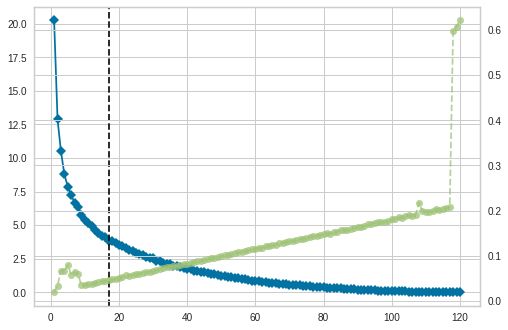

In [43]:
tracks_to_recommend = tracks.loc[pl3]
recommended, labels, centroids = rec.recommend_clusters(tracks_to_recommend)
print('Quantidade de clusters:', len(centroids))
for i,r in enumerate(recommended):
    print(f'Músicas pertecentes ao cluster {i+1}:')
    display(music_ids.loc[tracks_to_recommend[np.array(labels==i)].index])
    print(f'Recomendação para o cluster {i+1}:')
    display(r)